In [3]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, softmax
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
from torch_geometric.nn.conv import GATConv
import torch.nn.functional as F
from loader import BioDataset
from dataloader import DataLoaderFinetune
from torch_scatter import scatter_add
from torch_geometric.nn.inits import glorot, zeros
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch import Tensor
from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

from dataloader import DataLoaderFinetune
from splitters import random_split, species_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import torch.optim as optim

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

/nasdata3/kyj/anaconda3/envs/graphcl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import copy

import torch
from torch import Tensor
from torch_geometric.utils.subgraph import my_subgraph



class HalfHop:
    r"""Graph upsampling augmentation. Adds artifical slow nodes between neighbors to 
    slow down message propagation.

    ..note:: Use the :obj:`slow_node_mask` attribute to mask out the slow nodes after
    message passing.
    
    Args:
        alpha (float): The interpolation factor for the slow nodes.
        p (float): The probability of half-hopping an edge.
        inplace (bool): If set to :obj:`False`, will not modify the input graph
            and will instead return a new graph.
    """
    def __init__(self, alpha=0.5, p=1, inplace=True):
        assert 0. <= p <= 1., f"p must be in [0, 1], got {p}"
        assert 0. <= alpha <= 1., f"alpha must be in [0, 1], got {alpha}"

        self.p = p
        self.alpha = alpha

        self.inplace = inplace

    def __call__(self, data):
        if not self.inplace:
            data = copy.deepcopy(data)

        x, edge_index = data.x, data.edge_index
        device = data.x.device
        # first, isolate self loops which are not half-hopped
        self_loop_mask = edge_index[0] == edge_index[1]
        edge_index_self_loop = edge_index[:, self_loop_mask]
        edge_index = edge_index[:, ~self_loop_mask]
        

        # decide which edges to half-hop
        if self.p == 1.:
            # all edges are half-hopped
            edge_index_to_halfhop = edge_index
            edge_index_to_keep = None
        else:
            # randomly sample nodes and half-hop their edges
            node_mask = torch.rand(data.num_nodes, device=device) < self.p
            # print('node_mask', node_mask)
            # print('node_mask shape', node_mask.shape)
            # print('initial edge', edge_index[:,0])
            # print('initial edge shape', edge_index.shape)
            _, _, edge_mask = my_subgraph(node_mask, torch.stack([edge_index[1], edge_index[1]], dim=0), return_edge_mask=True)
            # print('edge_mask: ', edge_mask)
            # print('edge_mask shape', edge_mask.shape)
            edge_index_to_halfhop = edge_index[:, edge_mask]
            # print('edge_index_to_halfhop: ', edge_index_to_halfhop)
            # print('edge_index_to_halfhop shape', edge_index_to_halfhop.shape)
            edge_index_to_keep = Tensor(edge_index[:, ~edge_mask].to(torch.float)).to(torch.int64)

        # add new slow nodes, and use linear interpolation to initialize their features
        slow_node_ids = torch.arange(edge_index_to_halfhop.size(1), device=device) + data.num_nodes
        x_slow_node = x[edge_index_to_halfhop[0]]
        x_slow_node.mul_(self.alpha).add_(x[edge_index_to_halfhop[1]], alpha=1. - self.alpha)
        new_x = torch.cat([x, x_slow_node], dim=0)

        # add new edges between slow nodes and the original nodes that replace the original edges
        edge_index_slow = [
            torch.stack([edge_index_to_halfhop[0], slow_node_ids]),
            torch.stack([slow_node_ids, edge_index_to_halfhop[1]]),
            torch.stack([edge_index_to_halfhop[1], slow_node_ids])
            ]
        
        if self.p == 1.:
            new_edge_index = torch.cat([edge_index_self_loop, *edge_index_slow], dim=1)
        else:
            new_edge_index = torch.cat([edge_index_to_keep, edge_index_self_loop, *edge_index_slow], dim=1)

        # prepare a mask that distinguishes between original nodes and slow nodes
        slow_node_mask = torch.cat([
            torch.zeros(x.size(0), device=device),
            torch.ones(slow_node_ids.size(0), device=device)
        ], dim=0).bool()

        
        data.x, data.edge_index, data.slow_node_mask = new_x, new_edge_index, slow_node_mask

        return data

    def __repr__(self):
        return '{}(alpha={}, p={})'.format(self.__class__.__name__, self.alpha, self.p)

In [5]:
class GATConv(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    _alpha: OptTensor

    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, heads: int = 2, concat: bool = True,
                 negative_slope: float = 0.2, dropout: float = 0.0,
                 add_self_loops: bool = True, bias: bool = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(GATConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        
        if isinstance(in_channels, int):
            self.lin_l = Linear(in_channels, heads * out_channels, bias=False)
            self.lin_r = self.lin_l
        else:
            self.lin_l = Linear(in_channels[0], heads * out_channels, False)
            self.lin_r = Linear(in_channels[1], heads * out_channels, False)

        self.att_l = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = Parameter(torch.Tensor(1, heads, out_channels))

        if bias and concat:
            #self.bias = Parameter(torch.Tensor(heads * out_channels))
            self.bias = Parameter(torch.Tensor(out_channels))
            self.lin = Linear(heads * out_channels, out_channels, False)
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin_l.weight)
        glorot(self.lin_r.weight)
        glorot(self.att_l)
        glorot(self.att_r)
        zeros(self.bias)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None, return_attention_weights=None):
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        
        
        self_loop = 'no'    
        if self_loop =='no':
            self_loop_mask = edge_index[0] == edge_index[1]
            edge_index = edge_index[:, ~self_loop_mask]
        
        
        x_l: OptTensor = None
        x_r: OptTensor = None
        alpha_l: OptTensor = None
        alpha_r: OptTensor = None
        if isinstance(x, Tensor):
            assert x.dim() == 2, 'Static graphs not supported in `GATConv`.'
            x_l = x_r = self.lin_l(x).view(-1, H, C)
            alpha_l = (x_l * self.att_l).sum(dim=-1)
            alpha_r = (x_r * self.att_r).sum(dim=-1)
        else:
            x_l, x_r = x[0], x[1]
            assert x[0].dim() == 2, 'Static graphs not supported in `GATConv`.'
            x_l = self.lin_l(x_l).view(-1, H, C)
            alpha_l = (x_l * self.att_l).sum(dim=-1)
            if x_r is not None:
                x_r = self.lin_r(x_r).view(-1, H, C)
                alpha_r = (x_r * self.att_r).sum(dim=-1)

        assert x_l is not None
        assert alpha_l is not None

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                num_nodes = x_l.size(0)
                if x_r is not None:
                    num_nodes = min(num_nodes, x_r.size(0))
                if size is not None:
                    num_nodes = min(size[0], size[1])
                edge_index, _ = remove_self_loops(edge_index)
                edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                edge_index = set_diag(edge_index)

        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor)
        out = self.propagate(edge_index, x=(x_l, x_r),
                             alpha=(alpha_l, alpha_r), size=size)

        alpha = self._alpha
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
            out = self.lin(out)
            
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out += self.bias

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor,
                index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)


class GNN(torch.nn.Module):
    """
    Extension of GIN to incorporate edge information by concatenation.

    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        JK (str): last, concat, max or sum.
        max_pool_layer (int): the layer from which we use max pool rather than add pool for neighbor aggregation
        drop_ratio (float): dropout rate
        gnn_type: gin, gat, graphsage, gcn
        
    See https://arxiv.org/abs/1810.00826
    JK-net: https://arxiv.org/abs/1806.03536

    Output:
        node representations

    """
    def __init__(self, num_layer, emb_dim, JK = "last", drop_ratio = 0, gnn_type = "gin"):
        super(GNN, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK

        #if self.num_layer < 2:
        #    raise ValueError("Number of GNN layers must be greater than 1.")

        ###List of message-passing GNN convs
        self.gnns = torch.nn.ModuleList()
        
        if gnn_type == 'gat':
            if num_layer == 1:
                self.gnns.append(GATConv(116, emb_dim))
            else:
                self.gnns.append(GATConv(116, emb_dim))
                for layer in range(1, num_layer):
                    self.gnns.append(GATConv(emb_dim, emb_dim))
        else:
            for layer in range(num_layer):
                if layer == 0:
                    input_layer = True
                else:
                    input_layer = False

                if gnn_type == "gin":
                    self.gnns.append(GINConv(emb_dim, aggr = "add", input_layer = input_layer))
                elif gnn_type == "gcn":
                    self.gnns.append(GCNConv(emb_dim, input_layer = input_layer))
                # elif gnn_type == "gat":
                #     self.gnns.append(GATConv(emb_dim, input_layer = input_layer))
                elif gnn_type == "graphsage":
                    self.gnns.append(GraphSAGEConv(emb_dim, input_layer = input_layer))

    def forward(self, x, edge_index, edge_attr):
        h_list = [x]
        for layer in range(self.num_layer):
            h = self.gnns[layer](h_list[layer], edge_index, edge_attr)
            if layer == self.num_layer - 1:
                #remove relu from the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            h_list.append(h)

        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            h_list = [h.unsqueeze_(0) for h in h_list]
            node_representation = torch.sum(torch.cat(h_list[1:], dim = 0), dim = 0)[0]
        return node_representation

class GNN_graphpred(torch.nn.Module):
    """
    Extension of GIN to incorporate edge information by concatenation.

    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        num_tasks (int): number of tasks in multi-task learning scenario
        drop_ratio (float): dropout rate
        JK (str): last, concat, max or sum.
        graph_pooling (str): sum, mean, max, attention, set2set
        
    See https://arxiv.org/abs/1810.00826
    JK-net: https://arxiv.org/abs/1806.03536
    """
    def __init__(self, num_layer, emb_dim, num_tasks, JK = "last", drop_ratio = 0, graph_pooling = "mean", gnn_type = "gin"):
        super(GNN_graphpred, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.emb_dim = emb_dim
        self.num_tasks = num_tasks
        self.graph_pooling = graph_pooling

        #if self.num_layer < 2:
        #    raise ValueError("Number of GNN layers must be greater than 1.")

        self.gnn = GNN(num_layer, emb_dim, JK, drop_ratio, gnn_type = gnn_type)

        #Different kind of graph pooling
        if graph_pooling == "sum":
            self.pool = global_add_pool
        elif graph_pooling == "mean":
            self.mean_pool = global_mean_pool
            self.max_pool = global_max_pool
        elif graph_pooling == "max":
            self.pool = global_max_pool
        elif graph_pooling == "attention":
            self.pool = GlobalAttention(gate_nn = torch.nn.Linear(emb_dim, 1))
        else:
            raise ValueError("Invalid graph pooling type.")
        self.linear1 = torch.nn.Linear(self.emb_dim*2, 32)
        self.linear1_1 = torch.nn.Linear(self.emb_dim, 32)
        self.linear2 = torch.nn.Linear(128, 32)
        self.linear3 = torch.nn.Linear(32, 16)
        self.graph_pred_linear = torch.nn.Linear(32, self.num_tasks)
        self.softmax = torch.nn.Softmax(dim=1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def from_pretrained(self, model_file):
        self.gnn.load_state_dict(torch.load(model_file, map_location=lambda storage, loc: storage))

    def forward(self, data, do_visualize=False):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        node_representation = self.gnn(x, edge_index, edge_attr)
        
        if self.graph_pooling == 'mean': 
            mean_pooled = self.mean_pool(node_representation, batch)
            max_pooled = self.max_pool(node_representation, batch)
            pooled = torch.cat((mean_pooled, max_pooled), dim=1)
        else:
            pooled = self.pool(node_representation, batch)
        
        #graph_rep = torch.cat([pooled, center_node_rep], dim = 1)
        if self.graph_pooling == 'mean': 
            graph_rep = self.linear1(pooled)
        else:
            graph_rep = self.linear1_1(pooled)
        #graph_rep = self.linear2(graph_rep)
        #graph_rep = self.linear3(graph_rep)
    
  
        return self.softmax(self.graph_pred_linear(graph_rep))



In [16]:
device = 6
batch_size = 400
epochs = 1000
lr = 0.00001
decay = 0
num_layer = 1
emb_dim = 128
dropout_ratio = 0.5
graph_pooling = 'mean'
JK = 'last'
model_file = 'none'
gnn_type = 'gat'
seed = 42
runseed = 0
num_workers = 0
eval_train = 0
split = 'random'
resultFile_name = 'ABIDE1_ASD_CON_only_cc/edge20/gat_none_lr1e-5_epoch1000_batch400_decay0.00001_layer1_10fold_dim128_fc32'
num_tasks = 2
dataset_dir = 'dataset/spars20_supervised/abide_asd_cn/only_cc/processed/geometric_data_processed.pt'
kfold = 10
halfhop = 'no'
device = torch.device('cuda:'+str(device)) if torch.cuda.is_available() else torch.device("cpu")

In [18]:
criterion = nn.BCELoss()

def train(model, device, loader, val_loader, optimizer, num_tasks, halfhop):
    with torch.autograd.detect_anomaly():
        model.train()
        for step, batch in enumerate(tqdm(loader, desc="Iteration")):
            keep_batch = batch.batch
            # print('what is batch: ', batch.batch.shape)
            # if halfhop == 'yes':
            #     transform = HalfHop(alpha=0.5)
            #     batch = transform(batch)
            #     # print('what is transformed batch: ', batch)
            #     temp = torch.LongTensor([0]*int(int(batch.slow_node_mask.size(0))/int(batch.y.size(0))))
            #     # print('batch.y.size(0)',batch.y.size(0))
            #     # print('batch.x.size(1)',batch.x.size(1))
            #     # print('batch.slow_node_mask.size(0)', batch.slow_node_mask.size(0))
            #     # print('batch.y.size(0)', batch.y.size(0))
            #     for i in range(1,int(batch.y.size(0))):
            #         temp_1 = torch.LongTensor([i]*int(int(batch.slow_node_mask.size(0))/int(batch.y.size(0))))
            #         temp = torch.cat((temp,temp_1))
            #     batch.batch = temp
            batch = batch.to(device)

            # print("model.gnn",model.gnn.gnns)
            # print(model.gnn.gnns.GATConv)
            # summary(model.gnn.gnns, batch.x, batch.edge_index)
            pred = model(batch)
            
            #if halfhop == 'yes':
            #    pred = pred[~batch.slow_node_mask]
            y = F.one_hot(batch.y, num_classes=num_tasks)
            # print('y: ',y)
            # print('y: ',y.shape)
            # print('pred', pred)
            # print('pred.shape', pred.shape)
            y = y.view(pred.shape).to(torch.float64)
        
            optimizer.zero_grad()
            loss = criterion(pred.double(), y.double())
            loss.backward()
            #print(f'train_loss {loss}')
            
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        for i, data in enumerate(val_loader):
           
            data = data.to(device)
            val_pred = model(data)
            val_y = F.one_hot(data.y, num_classes=num_tasks)
            val_y = val_y.view(val_pred.shape).to(torch.float64)
        
            val_loss += criterion(val_pred.double(), val_y.double())
            print(f'validation loss {val_loss}')
        val_loss = val_loss/len(val_loader)  

    return loss.item(), val_loss.item() , val_y.double() , val_pred.double()
        
def eval( model, device, loader, num_tasks):
    model.eval()
    y_true = []
    y_scores = []
    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        #print("batch: ", batch)
        batch = batch.to(device)
        with torch.no_grad():
            pred = model(batch)
        
        y = F.one_hot(batch.y, num_classes=num_tasks)    
        y_true.append(y.view(pred.shape).detach().cpu())
        y_scores.append(pred.detach().cpu())
        
    y_true = torch.cat(y_true, dim = 0).numpy()
    y_scores = torch.cat(y_scores, dim = 0).numpy()
    
    
    
    roc_list = []
    fper_list = []
    tper_list = []

    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
            roc_list.append(roc_auc_score(y_true[:,i], y_scores[:,i]))
            fper, tper, _ = roc_curve(y_true[:,i], y_scores[:,i])
            #)
            fper_list.append(fper)
            tper_list.append(tper)
            
        else:
            roc_list.append(np.nan)
    
    y_pred_one_hot = []
    for i in range(len(y_scores)):
        if y_scores[i,0] < y_scores[i,1]:
            y_pred_new = 0
        else: y_pred_new = 1
        y_pred_one_hot.append(y_pred_new)      
    acc = accuracy_score(y_true[:,0], np.array(y_pred_one_hot))   
    cm = confusion_matrix(y_true[:,0],y_pred_one_hot)
    #print("acc",acc)    
    
    return np.array(roc_list),fper_list,tper_list, acc, cm  #y_true.shape[1]

/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



The fold is  1

val_index :  [  4   9  12  15  23  31  34  36  37  38  42  45  52  55  56  60  63  65
  66  70  89  92  96  97 103 105 111 117 120 121 122 123 126 131 133 134
 135 138 143 151 155 160 163 165 167 168 176 180 182 183 190 198 202 212
 215 222 226 227 239 240 243 250 252 256 264 276 288 289 290 299 300 319
 332 333 335 337 344 345 350 351 352 357 363 372 373 375 385 387 391 393
 394 397 398 402 404 405 408 412 414 418 419 422 429 435 436 441 442 446
 450 451 452 458 460 461 464 467 470 488 490 492 493 499 504 506 511 520
 521 524 525 526 529 530 535 539 543 544 547 549 552 562 564 566 567 570
 573 579 580 587 592 594 598 606 607 613 617 618 620 625 626 627 634 644
 647 648 657 660 665 669 671 679 680 682 685 691 704 707 713 715 718 722
 729 737 739 741 745 746 749 752]
The number of train dataset 565
The number of validation dataset 188
The number of test dataset 189
=====epoch 1


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


validation loss 0.6951494349924521
running_loss and val_running_loss:  0.6958170804272984 0.6951494349924521
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


test_auc [0.48731762 0.48731762]
test acc :  0.47619047619047616
=====epoch 2


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


validation loss 0.694808016803349
running_loss and val_running_loss:  0.6979679296445119 0.694808016803349
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]


test_auc [0.49685746 0.49685746]
test acc :  0.4708994708994709


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 3


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6945195987344256
running_loss and val_running_loss:  0.6869957567968564 0.6945195987344256
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


test_auc [0.50583614 0.50583614]
test acc :  0.4708994708994709


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 4


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6942694211731304
running_loss and val_running_loss:  0.6940409827052357 0.6942694211731304
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


test_auc [0.51268238 0.51268238]
test acc :  0.4708994708994709


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.64it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 5


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6940276040693704
running_loss and val_running_loss:  0.6925897748072091 0.6940276040693704
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s]


test_auc [0.52065095 0.52065095]
test acc :  0.4708994708994709


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 6


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.693798775610605
running_loss and val_running_loss:  0.6941966812505616 0.693798775610605
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


test_auc [0.52615039 0.52615039]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 7


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


validation loss 0.6935823052921013
running_loss and val_running_loss:  0.6951665765577802 0.6935823052921013
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


test_auc [0.5328844 0.5328844]
test acc :  0.5079365079365079


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 8


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


validation loss 0.6933816095661915
running_loss and val_running_loss:  0.6926892158077734 0.6933816095661915
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.54152637 0.54152637]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 9


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


validation loss 0.6932033663441779
running_loss and val_running_loss:  0.7010935416801952 0.6932033663441779
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


test_auc [0.54478114 0.54478114]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 10


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


validation loss 0.6930340355089722
running_loss and val_running_loss:  0.6933775247350464 0.6930340355089722
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


test_auc [0.54949495 0.54949495]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 11


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


validation loss 0.6928873442453761
running_loss and val_running_loss:  0.6930744515713275 0.6928873442453761
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


test_auc [0.55319865 0.55319865]
test acc :  0.5608465608465608


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 12


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


validation loss 0.6927587420126349
running_loss and val_running_loss:  0.6937378549651091 0.6927587420126349
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


test_auc [0.55858586 0.55858586]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 13


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6926398219493765
running_loss and val_running_loss:  0.6909264891942344 0.6926398219493765
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]


test_auc [0.5630752 0.5630752]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 14


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.692529782059451
running_loss and val_running_loss:  0.6925786259145954 0.692529782059451
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


test_auc [0.56689113 0.56689113]
test acc :  0.5132275132275133


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 15


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


validation loss 0.6924326976583198
running_loss and val_running_loss:  0.691101939390587 0.6924326976583198
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.57059484 0.57059484]
test acc :  0.5026455026455027


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 16


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


validation loss 0.692346765269637
running_loss and val_running_loss:  0.6936048881734646 0.692346765269637
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s]


test_auc [0.57138047 0.57138047]
test acc :  0.5079365079365079


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 17


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


validation loss 0.6922664544377785
running_loss and val_running_loss:  0.6950328029068008 0.6922664544377785
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]


test_auc [0.57508418 0.57508418]
test acc :  0.5026455026455027


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 18


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.692198380527002
running_loss and val_running_loss:  0.6912524183647865 0.692198380527002
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.49it/s]


test_auc [0.57710438 0.57710438]
test acc :  0.5026455026455027


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 19


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.6921352360265626
running_loss and val_running_loss:  0.6928639679233689 0.6921352360265626
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


test_auc [0.58080808 0.58075196]
test acc :  0.5132275132275133


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 20


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


validation loss 0.6920810399388442
running_loss and val_running_loss:  0.6922433372424803 0.6920810399388442
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


test_auc [0.58260382 0.58260382]
test acc :  0.5185185185185185


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 21


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


validation loss 0.6920342497134923
running_loss and val_running_loss:  0.6930516692852615 0.6920342497134923
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]


test_auc [0.58361392 0.58361392]
test acc :  0.5185185185185185


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 22


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


validation loss 0.6919945502891365
running_loss and val_running_loss:  0.6917410075591888 0.6919945502891365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


test_auc [0.58496072 0.58496072]
test acc :  0.5185185185185185


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 23


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6919590642096886
running_loss and val_running_loss:  0.6925751458755488 0.6919590642096886
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


test_auc [0.58563412 0.58563412]
test acc :  0.5185185185185185


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 24


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


validation loss 0.6919285382274841
running_loss and val_running_loss:  0.6907340462045026 0.6919285382274841
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


test_auc [0.58720539 0.58720539]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 25


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


validation loss 0.6919011551776549
running_loss and val_running_loss:  0.690300656849478 0.6919011551776549
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]


test_auc [0.58799102 0.58799102]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 26


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


validation loss 0.6918761994977365
running_loss and val_running_loss:  0.6920375674816325 0.6918761994977365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]


test_auc [0.58967452 0.58967452]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 27


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6918525625512215
running_loss and val_running_loss:  0.6914738265880387 0.6918525625512215
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]


test_auc [0.58945006 0.58945006]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 28


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


validation loss 0.6918299417276859
running_loss and val_running_loss:  0.692705938012674 0.6918299417276859
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s]


test_auc [0.59079686 0.59079686]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 29


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


validation loss 0.6918085463673056
running_loss and val_running_loss:  0.6859363102365322 0.6918085463673056
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


test_auc [0.59124579 0.59124579]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 30


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


validation loss 0.6917872013506675
running_loss and val_running_loss:  0.6937644488466291 0.6917872013506675
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]


test_auc [0.59158249 0.59158249]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 31


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6917682020818842
running_loss and val_running_loss:  0.6923004973839134 0.6917682020818842
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


test_auc [0.59236813 0.59236813]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 32


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


validation loss 0.6917487703085369
running_loss and val_running_loss:  0.6912008297021539 0.6917487703085369
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


test_auc [0.59270483 0.59270483]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 33


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6917298987020285
running_loss and val_running_loss:  0.6927614836095661 0.6917298987020285
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


test_auc [0.59427609 0.59427609]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 34


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6917111992798746
running_loss and val_running_loss:  0.6904428097422779 0.6917111992798746
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s]


test_auc [0.59393939 0.59393939]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 35


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


validation loss 0.6916934981579222
running_loss and val_running_loss:  0.6878120584144718 0.6916934981579222
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


test_auc [0.59393939 0.59393939]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 36


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


validation loss 0.6916756937994201
running_loss and val_running_loss:  0.6924707220430761 0.6916756937994201
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]


test_auc [0.59483726 0.59483726]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 37


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6916563228301159
running_loss and val_running_loss:  0.692364996869718 0.6916563228301159
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


test_auc [0.59494949 0.59494949]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 38


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


validation loss 0.691635942385221
running_loss and val_running_loss:  0.689131638953692 0.691635942385221
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


test_auc [0.59506173 0.59506173]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 39


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


validation loss 0.6916162740664239
running_loss and val_running_loss:  0.6921757387363898 0.6916162740664239
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


test_auc [0.59618406 0.59618406]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 40


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


validation loss 0.6915974652723688
running_loss and val_running_loss:  0.6913309758431965 0.6915974652723688
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


test_auc [0.5962963 0.5962963]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 41


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6915786372963453
running_loss and val_running_loss:  0.6934286905477274 0.6915786372963453
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


test_auc [0.59674523 0.59674523]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 42


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6915602075561283
running_loss and val_running_loss:  0.6889702240317296 0.6915602075561283
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


test_auc [0.5969697 0.5969697]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 43


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


validation loss 0.6915412680616253
running_loss and val_running_loss:  0.6887984498074978 0.6915412680616253
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


test_auc [0.59753086 0.59753086]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 44


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6915226453671149
running_loss and val_running_loss:  0.6840586029868658 0.6915226453671149
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.26it/s]


test_auc [0.5976431 0.5976431]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 45


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


validation loss 0.6915056454964644
running_loss and val_running_loss:  0.6848779835093655 0.6915056454964644
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.40it/s]


test_auc [0.5979798 0.5979798]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 46


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


validation loss 0.6914893747233279
running_loss and val_running_loss:  0.6888115119315702 0.6914893747233279
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s]


test_auc [0.59876543 0.59876543]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 47


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


validation loss 0.6914719443745663
running_loss and val_running_loss:  0.6905457841567537 0.6914719443745663
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


test_auc [0.59988777 0.59988777]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 48


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


validation loss 0.6914543679318281
running_loss and val_running_loss:  0.6910309119719366 0.6914543679318281
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


test_auc [0.60089787 0.60089787]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 49


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6914355766194029
running_loss and val_running_loss:  0.6856885991461695 0.6914355766194029
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.71it/s]


test_auc [0.60157127 0.60157127]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 50


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


validation loss 0.6914179291227616
running_loss and val_running_loss:  0.6907869098603912 0.6914179291227616
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


test_auc [0.60246914 0.60246914]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 51


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


validation loss 0.6913994919858382
running_loss and val_running_loss:  0.6935637626382831 0.6913994919858382
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]


test_auc [0.60280584 0.60280584]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 52


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


validation loss 0.6913800170253136
running_loss and val_running_loss:  0.6866733603910478 0.6913800170253136
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


test_auc [0.60325477 0.60325477]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 53


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


validation loss 0.691360762576093
running_loss and val_running_loss:  0.6923093176189975 0.691360762576093
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]


test_auc [0.60392817 0.60392817]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 54


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


validation loss 0.6913402698679212
running_loss and val_running_loss:  0.6916092853437819 0.6913402698679212
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


test_auc [0.6037037 0.6037037]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 55


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


validation loss 0.6913195498516902
running_loss and val_running_loss:  0.6901293221536046 0.6913195498516902
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


test_auc [0.6040404 0.6040404]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 56


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6912993443535886
running_loss and val_running_loss:  0.6881453194242922 0.6912993443535886
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.40it/s]


test_auc [0.60426487 0.60426487]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 57


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.691279450611702
running_loss and val_running_loss:  0.6868809741072427 0.691279450611702
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


test_auc [0.60538721 0.60538721]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 58


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


validation loss 0.6912606771495476
running_loss and val_running_loss:  0.6947380491064329 0.6912606771495476
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.81it/s]


test_auc [0.60561167 0.60561167]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 59


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


validation loss 0.6912410824174287
running_loss and val_running_loss:  0.6892382488428108 0.6912410824174287
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


test_auc [0.60662177 0.60662177]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.64it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 60


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


validation loss 0.691220988886216
running_loss and val_running_loss:  0.6870183398818508 0.691220988886216
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]


test_auc [0.60707071 0.60707071]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 61


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


validation loss 0.6912015294907786
running_loss and val_running_loss:  0.6894596638602608 0.6912015294907786
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


test_auc [0.60763187 0.60763187]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 62


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


validation loss 0.6911826259941876
running_loss and val_running_loss:  0.6897367169121645 0.6911826259941876
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.44it/s]


test_auc [0.60886644 0.60886644]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 63


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


validation loss 0.6911638819947202
running_loss and val_running_loss:  0.688250400091149 0.6911638819947202
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


test_auc [0.60909091 0.60909091]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 64


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6911457609110232
running_loss and val_running_loss:  0.6911274270683877 0.6911457609110232
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.60909091 0.60909091]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 65


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


validation loss 0.6911285384980259
running_loss and val_running_loss:  0.6874294761814553 0.6911285384980259
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s]


test_auc [0.60920314 0.60920314]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 66


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.6911109342861014
running_loss and val_running_loss:  0.6862387388514101 0.6911109342861014
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


test_auc [0.60976431 0.60976431]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 67


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6910932495703728
running_loss and val_running_loss:  0.6944636798941287 0.6910932495703728
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


test_auc [0.61099888 0.61099888]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 68


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.691077602150229
running_loss and val_running_loss:  0.6905833009821835 0.691077602150229
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.21it/s]


test_auc [0.61223345 0.61223345]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.57it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 69


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


validation loss 0.6910625564648324
running_loss and val_running_loss:  0.6906545932202828 0.6910625564648324
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


test_auc [0.61212121 0.61212121]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 70


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


validation loss 0.6910470512133198
running_loss and val_running_loss:  0.6827247795821886 0.6910470512133198
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


test_auc [0.61290685 0.61290685]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 71


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


validation loss 0.6910296013139355
running_loss and val_running_loss:  0.6870981641977641 0.6910296013139355
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


test_auc [0.61301908 0.61301908]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 72


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6910121660205495
running_loss and val_running_loss:  0.6879369784164915 0.6910121660205495
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.28it/s]


test_auc [0.61391695 0.61391695]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 73


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6909953824873969
running_loss and val_running_loss:  0.6880014150508194 0.6909953824873969
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


test_auc [0.61459035 0.61459035]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 74


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]


validation loss 0.6909776005615
running_loss and val_running_loss:  0.6838133837173906 0.6909776005615
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.18it/s]


test_auc [0.61548822 0.61548822]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 75


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


validation loss 0.690960250636893
running_loss and val_running_loss:  0.6868739779579894 0.690960250636893
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


test_auc [0.61661055 0.61661055]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 76


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.6909441351776281
running_loss and val_running_loss:  0.6910300461110477 0.6909441351776281
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


test_auc [0.61649832 0.61649832]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 77


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


validation loss 0.6909289758657067
running_loss and val_running_loss:  0.6882319422738985 0.6909289758657067
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]


test_auc [0.61638608 0.61638608]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 78


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


validation loss 0.6909136889665534
running_loss and val_running_loss:  0.691972608628667 0.6909136889665534
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


test_auc [0.61672278 0.61672278]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 79


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


validation loss 0.6908977954766667
running_loss and val_running_loss:  0.6811801404200634 0.6908977954766667
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


test_auc [0.61762065 0.61762065]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 80


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


validation loss 0.6908814859329557
running_loss and val_running_loss:  0.686443796040392 0.6908814859329557
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s]


test_auc [0.61806958 0.61806958]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 81


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6908667531910511
running_loss and val_running_loss:  0.6894026148394711 0.6908667531910511
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


test_auc [0.61806958 0.61806958]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 82


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


validation loss 0.690851966017174
running_loss and val_running_loss:  0.688557233246152 0.690851966017174
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]


test_auc [0.61874299 0.61874299]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 83


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


validation loss 0.6908367947007803
running_loss and val_running_loss:  0.6872282490016202 0.6908367947007803
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.86it/s]


test_auc [0.61896745 0.61896745]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 84


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.690821585563212
running_loss and val_running_loss:  0.6868060169717328 0.690821585563212
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


test_auc [0.61919192 0.61919192]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 85


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


validation loss 0.6908073883095346
running_loss and val_running_loss:  0.6894184737965402 0.6908073883095346
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


test_auc [0.61930415 0.61930415]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 86


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6907942278854065
running_loss and val_running_loss:  0.6830285617694979 0.6907942278854065
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


test_auc [0.61930415 0.61930415]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 87


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


validation loss 0.6907825543136552
running_loss and val_running_loss:  0.689909912476066 0.6907825543136552
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


test_auc [0.61941639 0.61941639]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 88


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


validation loss 0.6907694874959499
running_loss and val_running_loss:  0.6852588546682773 0.6907694874959499
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


test_auc [0.61919192 0.61919192]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 89


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


validation loss 0.690756354885397
running_loss and val_running_loss:  0.6859312037180472 0.690756354885397
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]


test_auc [0.61964085 0.61964085]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 90


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6907424069412282
running_loss and val_running_loss:  0.6852217773911806 0.6907424069412282
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


test_auc [0.61997755 0.61997755]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 91


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


validation loss 0.6907279703160001
running_loss and val_running_loss:  0.6803255904726168 0.6907279703160001
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


test_auc [0.61997755 0.61997755]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 92


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6907157565973537
running_loss and val_running_loss:  0.6879561254468396 0.6907157565973537
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


test_auc [0.61986532 0.61986532]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 93


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


validation loss 0.6907022582752291
running_loss and val_running_loss:  0.682028603097303 0.6907022582752291
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s]


test_auc [0.61997755 0.61997755]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 94


Iteration: 100%|██████████| 2/2 [00:00<00:00,  7.68it/s]


validation loss 0.6906901727294498
running_loss and val_running_loss:  0.6897286353809513 0.6906901727294498
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


test_auc [0.62042649 0.62042649]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 95


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.6906763043169362
running_loss and val_running_loss:  0.6824901808284798 0.6906763043169362
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]


test_auc [0.62121212 0.62121212]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 96


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


validation loss 0.6906631859172416
running_loss and val_running_loss:  0.6873672250966203 0.6906631859172416
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s]


test_auc [0.62121212 0.62121212]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 97


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


validation loss 0.6906475185224588
running_loss and val_running_loss:  0.6894932843863871 0.6906475185224588
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


test_auc [0.62076319 0.62076319]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 98


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


validation loss 0.690630879230259
running_loss and val_running_loss:  0.6869727454325998 0.690630879230259
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


test_auc [0.62109989 0.62109989]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 99


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


validation loss 0.6906125974569755
running_loss and val_running_loss:  0.6795181358621637 0.6906125974569755
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


test_auc [0.62143659 0.62143659]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 100


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6905964032395278
running_loss and val_running_loss:  0.6886237993960176 0.6905964032395278
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]


test_auc [0.62132435 0.62132435]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 101


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6905782109744604
running_loss and val_running_loss:  0.6786903735386153 0.6905782109744604
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


test_auc [0.62188552 0.62188552]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 102


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


validation loss 0.6905633689269489
running_loss and val_running_loss:  0.6911210389912162 0.6905633689269489
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]


test_auc [0.62210999 0.62210999]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 103


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6905473506236471
running_loss and val_running_loss:  0.6788337056764158 0.6905473506236471
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]


test_auc [0.62267116 0.62267116]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 104


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


validation loss 0.6905339841811488
running_loss and val_running_loss:  0.6822886986461216 0.6905339841811488
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]


test_auc [0.62244669 0.62244669]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 105


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.6905209045145595
running_loss and val_running_loss:  0.6855398008929545 0.6905209045145595
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


test_auc [0.62278339 0.62278339]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 106


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


validation loss 0.6905040117784178
running_loss and val_running_loss:  0.6924701585859385 0.6905040117784178
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


test_auc [0.62289562 0.62289562]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 107


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


validation loss 0.6904832052631805
running_loss and val_running_loss:  0.6849201587748303 0.6904832052631805
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


test_auc [0.62368126 0.62368126]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 108


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.6904656814263085
running_loss and val_running_loss:  0.6802161542763575 0.6904656814263085
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.62368126 0.62368126]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 109


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


validation loss 0.6904522329923893
running_loss and val_running_loss:  0.6850156060630286 0.6904522329923893
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


test_auc [0.62345679 0.62345679]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 110


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


validation loss 0.6904399882690337
running_loss and val_running_loss:  0.6806571433452121 0.6904399882690337
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]


test_auc [0.62435466 0.62435466]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 111


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.6904313107398014
running_loss and val_running_loss:  0.6809957005246133 0.6904313107398014
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s]


test_auc [0.62491582 0.62491582]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 112


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.6904210604036114
running_loss and val_running_loss:  0.6899443184870785 0.6904210604036114
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]


test_auc [0.62514029 0.62514029]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 113


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6904041066998241
running_loss and val_running_loss:  0.6914729740768337 0.6904041066998241
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


test_auc [0.62581369 0.62581369]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 114


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


validation loss 0.6903781753629802
running_loss and val_running_loss:  0.6908061855065936 0.6903781753629802
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s]


test_auc [0.62558923 0.62558923]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 115


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


validation loss 0.690346523903421
running_loss and val_running_loss:  0.6849379145075019 0.690346523903421
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


test_auc [0.62547699 0.62547699]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 116


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


validation loss 0.6903161359508994
running_loss and val_running_loss:  0.6938277939690871 0.6903161359508994
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.50it/s]


test_auc [0.62615039 0.62615039]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 117


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


validation loss 0.6902865031838973
running_loss and val_running_loss:  0.6837547511501917 0.6902865031838973
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]


test_auc [0.62704826 0.62704826]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 118


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


validation loss 0.6902604682781729
running_loss and val_running_loss:  0.6956515728911983 0.6902604682781729
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


test_auc [0.6285073 0.6285073]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 119


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


validation loss 0.6902320589596636
running_loss and val_running_loss:  0.6939076021241996 0.6902320589596636
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.20it/s]


test_auc [0.62962963 0.62962963]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 120


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]


validation loss 0.6902070056066
running_loss and val_running_loss:  0.6788716533691668 0.6902070056066
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]


test_auc [0.63002245 0.62996633]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 121


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6901877150317706
running_loss and val_running_loss:  0.6844236028898127 0.6901877150317706
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


test_auc [0.63075196 0.63075196]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 122


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6901687788936787
running_loss and val_running_loss:  0.6840415203713539 0.6901687788936787
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s]


test_auc [0.6305275 0.6305275]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 123


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6901506639937318
running_loss and val_running_loss:  0.6823264874299064 0.6901506639937318
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


test_auc [0.6312009 0.6312009]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 124


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6901323086901314
running_loss and val_running_loss:  0.6808514050954503 0.6901323086901314
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s]


test_auc [0.63097643 0.63097643]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 125


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6901142028349737
running_loss and val_running_loss:  0.6846220448500471 0.6901142028349737
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]


test_auc [0.63108866 0.63108866]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 126


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6900957755055795
running_loss and val_running_loss:  0.6836842702965154 0.6900957755055795
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


test_auc [0.6315376 0.6315376]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 127


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6900783728040109
running_loss and val_running_loss:  0.6823130349202028 0.6900783728040109
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.63142536 0.63142536]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 128


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


validation loss 0.6900612266316557
running_loss and val_running_loss:  0.6812720074880618 0.6900612266316557
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


test_auc [0.63097643 0.63097643]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 129


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


validation loss 0.6900434408127861
running_loss and val_running_loss:  0.6855162889247186 0.6900434408127861
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


test_auc [0.6312009 0.6312009]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 130


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


validation loss 0.6900263901179077
running_loss and val_running_loss:  0.6771139219476078 0.6900263901179077
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


test_auc [0.63164983 0.63164983]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 131


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


validation loss 0.6900107095137039
running_loss and val_running_loss:  0.6803298501738866 0.6900107095137039
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


test_auc [0.63209877 0.63209877]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 132


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.689996338279466
running_loss and val_running_loss:  0.6800601301465936 0.689996338279466
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


test_auc [0.632211 0.632211]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 133


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


validation loss 0.6899838844335415
running_loss and val_running_loss:  0.6814388855997968 0.6899838844335415
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]


test_auc [0.632211 0.632211]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 134


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


validation loss 0.6899726316548447
running_loss and val_running_loss:  0.679815660845785 0.6899726316548447
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


test_auc [0.63232323 0.63232323]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 135


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


validation loss 0.6899619267623416
running_loss and val_running_loss:  0.6846183617747652 0.6899619267623416
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.34it/s]


test_auc [0.63142536 0.63142536]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 136


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


validation loss 0.6899504873922291
running_loss and val_running_loss:  0.6904073770182312 0.6899504873922291
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.20it/s]


test_auc [0.63198653 0.63198653]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 137


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.689935955306974
running_loss and val_running_loss:  0.685604640539828 0.689935955306974
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


test_auc [0.63243547 0.63243547]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 138


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


validation loss 0.6899203268910546
running_loss and val_running_loss:  0.6796317676106592 0.6899203268910546
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


test_auc [0.63333333 0.63333333]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 139


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


validation loss 0.6899044475585498
running_loss and val_running_loss:  0.6823785183782056 0.6899044475585498
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.63367003 0.63367003]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 140


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.689887139569947
running_loss and val_running_loss:  0.6857300215961136 0.689887139569947
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


test_auc [0.6338945 0.6338945]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 141


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


validation loss 0.6898648588283176
running_loss and val_running_loss:  0.6960818513856981 0.6898648588283176
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.6335578 0.6335578]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 142


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


validation loss 0.6898387791424809
running_loss and val_running_loss:  0.686062937154121 0.6898387791424809
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]


test_auc [0.63378227 0.63378227]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 143


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


validation loss 0.6898150363698158
running_loss and val_running_loss:  0.6757782398743207 0.6898150363698158
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s]


test_auc [0.63411897 0.63411897]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 144


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


validation loss 0.6897938327126589
running_loss and val_running_loss:  0.6892690952822756 0.6897938327126589
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.22it/s]


test_auc [0.63367003 0.63367003]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 145


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


validation loss 0.6897733615854141
running_loss and val_running_loss:  0.6768970480199166 0.6897733615854141
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]


test_auc [0.6345679 0.6345679]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 146


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


validation loss 0.6897536889199236
running_loss and val_running_loss:  0.6834082025720924 0.6897536889199236
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


test_auc [0.63501684 0.63501684]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 147


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6897346052026939
running_loss and val_running_loss:  0.6836872757149735 0.6897346052026939
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]


test_auc [0.63445567 0.63445567]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 148


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


validation loss 0.6897159022414712
running_loss and val_running_loss:  0.6798408997535497 0.6897159022414712
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]


test_auc [0.63479237 0.63479237]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 149


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


validation loss 0.6896985604765408
running_loss and val_running_loss:  0.684848652060001 0.6896985604765408
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


test_auc [0.63535354 0.63535354]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 150


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6896806034659705
running_loss and val_running_loss:  0.6835505526631275 0.6896806034659705
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


test_auc [0.63512907 0.63512907]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 151


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


validation loss 0.6896631569683815
running_loss and val_running_loss:  0.6815369429702526 0.6896631569683815
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


test_auc [0.63546577 0.63546577]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.59it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 152


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


validation loss 0.689646876860698
running_loss and val_running_loss:  0.6905102883684477 0.689646876860698
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.47it/s]


test_auc [0.6352413 0.6352413]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 153


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


validation loss 0.6896287997514864
running_loss and val_running_loss:  0.6837946797043637 0.6896287997514864
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


test_auc [0.63512907 0.63512907]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 154


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6896092436955503
running_loss and val_running_loss:  0.6758629083743848 0.6896092436955503
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]


test_auc [0.63569024 0.63569024]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 155


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


validation loss 0.6895899287914653
running_loss and val_running_loss:  0.6813264148827297 0.6895899287914653
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.29it/s]


test_auc [0.6362514 0.6362514]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 156


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


validation loss 0.6895693826122044
running_loss and val_running_loss:  0.6750143130039462 0.6895693826122044
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]


test_auc [0.63681257 0.63681257]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 157


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


validation loss 0.689552635747648
running_loss and val_running_loss:  0.6878238993498408 0.689552635747648
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


test_auc [0.6369248 0.6369248]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 158


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


validation loss 0.6895347137511119
running_loss and val_running_loss:  0.6843760947189654 0.6895347137511119
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


test_auc [0.63681257 0.63681257]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 159


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6895155377363563
running_loss and val_running_loss:  0.6843439274378083 0.6895155377363563
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]


test_auc [0.63703704 0.63703704]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 160


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


validation loss 0.6894961570487527
running_loss and val_running_loss:  0.6774408402532365 0.6894961570487527
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]


test_auc [0.63737374 0.63737374]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 161


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


validation loss 0.6894778480133142
running_loss and val_running_loss:  0.6794189857347521 0.6894778480133142
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s]


test_auc [0.63714927 0.63714927]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 162


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


validation loss 0.6894597830870457
running_loss and val_running_loss:  0.6825175892798748 0.6894597830870457
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


test_auc [0.63782267 0.63782267]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 163


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


validation loss 0.6894422661165194
running_loss and val_running_loss:  0.6809462341843203 0.6894422661165194
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


test_auc [0.63804714 0.63804714]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 164


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


validation loss 0.6894236660539342
running_loss and val_running_loss:  0.6795853457755306 0.6894236660539342
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


test_auc [0.63849607 0.63849607]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 165


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6894056488610693
running_loss and val_running_loss:  0.6805824708309596 0.6894056488610693
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]


test_auc [0.63883277 0.63883277]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 166


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


validation loss 0.6893883046132848
running_loss and val_running_loss:  0.6776952827921953 0.6893883046132848
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.63872054 0.63872054]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 167


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.68937229559003
running_loss and val_running_loss:  0.676060311041709 0.68937229559003
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.47it/s]


test_auc [0.6382716 0.6382716]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 168


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


validation loss 0.6893586717134669
running_loss and val_running_loss:  0.6880296976118409 0.6893586717134669
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.6372615 0.6372615]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 169


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6893429118308235
running_loss and val_running_loss:  0.6818608427614411 0.6893429118308235
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


test_auc [0.6372615 0.6372615]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 170


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.68932778094662
running_loss and val_running_loss:  0.6865590190061835 0.68932778094662
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


test_auc [0.6372615 0.6372615]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 171


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


validation loss 0.6893108574698377
running_loss and val_running_loss:  0.6801152080048152 0.6893108574698377
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


test_auc [0.63815937 0.63815937]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 172


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


validation loss 0.6892956529132671
running_loss and val_running_loss:  0.692133740146253 0.6892956529132671
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]


test_auc [0.63872054 0.63872054]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 173


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


validation loss 0.6892771093619888
running_loss and val_running_loss:  0.6740848254978976 0.6892771093619888
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


test_auc [0.63883277 0.63883277]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 174


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


validation loss 0.6892614595835549
running_loss and val_running_loss:  0.6803413263986069 0.6892614595835549
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s]


test_auc [0.63872054 0.63872054]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 175


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


validation loss 0.6892455680595339
running_loss and val_running_loss:  0.6766451964946779 0.6892455680595339
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


test_auc [0.63939394 0.63939394]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 176


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6892289685346553
running_loss and val_running_loss:  0.6868780373047335 0.6892289685346553
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s]


test_auc [0.63961841 0.63961841]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 177


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


validation loss 0.6892100273376751
running_loss and val_running_loss:  0.6789235689791083 0.6892100273376751
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


test_auc [0.64017957 0.64017957]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 178


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


validation loss 0.6891920269042408
running_loss and val_running_loss:  0.6892605716678595 0.6891920269042408
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


test_auc [0.64029181 0.64029181]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 179


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6891720745450038
running_loss and val_running_loss:  0.6800376450048874 0.6891720745450038
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


test_auc [0.64006734 0.64006734]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 180


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6891542352591106
running_loss and val_running_loss:  0.6736468808007129 0.6891542352591106
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


test_auc [0.64017957 0.64017957]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 181


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


validation loss 0.689139646217734
running_loss and val_running_loss:  0.6827750859079439 0.689139646217734
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


test_auc [0.64017957 0.64017957]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 182


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


validation loss 0.6891236020482583
running_loss and val_running_loss:  0.6827869756800291 0.6891236020482583
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


test_auc [0.64062851 0.64062851]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 183


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


validation loss 0.6891069550412459
running_loss and val_running_loss:  0.6864841220212593 0.6891069550412459
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


test_auc [0.64085297 0.64085297]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 184


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


validation loss 0.6890872567063326
running_loss and val_running_loss:  0.6870301888258519 0.6890872567063326
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]


test_auc [0.64090909 0.64090909]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 185


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6890668581814401
running_loss and val_running_loss:  0.6826147663067841 0.6890668581814401
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


test_auc [0.64130191 0.64130191]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 186


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.6890466931953638
running_loss and val_running_loss:  0.676817700735606 0.6890466931953638
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


test_auc [0.64163861 0.64163861]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 187


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.6890266977256946
running_loss and val_running_loss:  0.6827878456177014 0.6890266977256946
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


test_auc [0.64163861 0.64163861]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 188


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


validation loss 0.6890069530932124
running_loss and val_running_loss:  0.6843011923755957 0.6890069530932124
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.99it/s]


test_auc [0.64186308 0.64186308]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 189


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


validation loss 0.6889875573382478
running_loss and val_running_loss:  0.6776705771851678 0.6889875573382478
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s]


test_auc [0.64152637 0.64152637]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 190


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


validation loss 0.6889702954333857
running_loss and val_running_loss:  0.6849625533717831 0.6889702954333857
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s]


test_auc [0.64186308 0.64186308]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 191


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


validation loss 0.6889522921378795
running_loss and val_running_loss:  0.6762633322959624 0.6889522921378795
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


test_auc [0.64242424 0.64242424]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 192


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6889337355643741
running_loss and val_running_loss:  0.677807372184195 0.6889337355643741
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.64298541 0.64298541]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 193


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


validation loss 0.6889152585434225
running_loss and val_running_loss:  0.6847362327568182 0.6889152585434225
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


test_auc [0.64343434 0.64343434]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 194


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


validation loss 0.6888971570140524
running_loss and val_running_loss:  0.6749692093822764 0.6888971570140524
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


test_auc [0.64377104 0.64377104]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 195


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6888807268333722
running_loss and val_running_loss:  0.6832344235809902 0.6888807268333722
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]


test_auc [0.64388328 0.64388328]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 196


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


validation loss 0.6888633280646581
running_loss and val_running_loss:  0.6772642548835448 0.6888633280646581
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


test_auc [0.64399551 0.64399551]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 197


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


validation loss 0.6888466722190696
running_loss and val_running_loss:  0.6825832005777549 0.6888466722190696
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


test_auc [0.64399551 0.64399551]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 198


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


validation loss 0.6888285492476639
running_loss and val_running_loss:  0.6781834448338621 0.6888285492476639
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


test_auc [0.64388328 0.64388328]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 199


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


validation loss 0.6888101140230336
running_loss and val_running_loss:  0.6743881914021538 0.6888101140230336
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


test_auc [0.64421998 0.64421998]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 200


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


validation loss 0.6887922991891082
running_loss and val_running_loss:  0.682387800913781 0.6887922991891082
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.59it/s]


test_auc [0.64433221 0.64433221]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 201


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6887745144210171
running_loss and val_running_loss:  0.6751510591776703 0.6887745144210171
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


test_auc [0.64478114 0.64478114]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 202


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6887587348730345
running_loss and val_running_loss:  0.6780857439041171 0.6887587348730345
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


test_auc [0.64489338 0.64489338]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 203


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


validation loss 0.6887446862131463
running_loss and val_running_loss:  0.6763370256840381 0.6887446862131463
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


test_auc [0.64500561 0.64500561]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 204


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


validation loss 0.6887317926946274
running_loss and val_running_loss:  0.6838817236454201 0.6887317926946274
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]


test_auc [0.64489338 0.64489338]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 205


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


validation loss 0.688717516430529
running_loss and val_running_loss:  0.676755593774303 0.688717516430529
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


test_auc [0.64511785 0.64511785]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 206


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


validation loss 0.6887012079900778
running_loss and val_running_loss:  0.6728787788793724 0.6887012079900778
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]


test_auc [0.64534231 0.64534231]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 207


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


validation loss 0.6886862866372592
running_loss and val_running_loss:  0.6745910016259015 0.6886862866372592
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]


test_auc [0.64500561 0.64500561]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 208


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6886724132276826
running_loss and val_running_loss:  0.6749676402097451 0.6886724132276826
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


test_auc [0.64523008 0.64523008]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 209


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


validation loss 0.6886590681896002
running_loss and val_running_loss:  0.6724619696761004 0.6886590681896002
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.08it/s]


test_auc [0.64523008 0.64523008]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 210


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.6886485264344753
running_loss and val_running_loss:  0.677305848848124 0.6886485264344753
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


test_auc [0.64523008 0.64523008]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 211


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


validation loss 0.6886373703186602
running_loss and val_running_loss:  0.6714145950415144 0.6886373703186602
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


test_auc [0.64455668 0.64455668]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 212


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


validation loss 0.6886305334847519
running_loss and val_running_loss:  0.6768611239161271 0.6886305334847519
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


test_auc [0.64455668 0.64455668]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 213


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6886236413893005
running_loss and val_running_loss:  0.6847890228200016 0.6886236413893005
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


test_auc [0.64466891 0.64466891]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 214


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6886097237941866
running_loss and val_running_loss:  0.6808354243052818 0.6886097237941866
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s]


test_auc [0.64466891 0.64466891]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 215


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


validation loss 0.6885916610129789
running_loss and val_running_loss:  0.6816837581115347 0.6885916610129789
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


test_auc [0.64455668 0.64455668]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 216


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


validation loss 0.6885731429088293
running_loss and val_running_loss:  0.6666522099998791 0.6885731429088293
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


test_auc [0.64466891 0.64466891]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 217


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


validation loss 0.6885572655586674
running_loss and val_running_loss:  0.6796365726908435 0.6885572655586674
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


test_auc [0.64489338 0.64489338]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 218


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


validation loss 0.6885371371473957
running_loss and val_running_loss:  0.6695364418664639 0.6885371371473957
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s]


test_auc [0.64511785 0.64511785]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 219


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


validation loss 0.6885195379655036
running_loss and val_running_loss:  0.6776812079735981 0.6885195379655036
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.64523008 0.64523008]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 220


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


validation loss 0.6884983091326983
running_loss and val_running_loss:  0.6853452829240145 0.6884983091326983
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


test_auc [0.64523008 0.64523008]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 221


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6884688448358798
running_loss and val_running_loss:  0.6749351547336738 0.6884688448358798
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


test_auc [0.64680135 0.64680135]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 222


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6884404319426627
running_loss and val_running_loss:  0.6664473609504864 0.6884404319426627
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


test_auc [0.64668911 0.64668911]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 223


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


validation loss 0.6884208563305968
running_loss and val_running_loss:  0.6786088920989338 0.6884208563305968
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


test_auc [0.64713805 0.64713805]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 224


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


validation loss 0.6884009539342997
running_loss and val_running_loss:  0.6797756848993396 0.6884009539342997
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.38it/s]


test_auc [0.64713805 0.64713805]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 225


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


validation loss 0.6883814137092635
running_loss and val_running_loss:  0.6839039793890545 0.6883814137092635
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


test_auc [0.64725028 0.64725028]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 226


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6883592350355056
running_loss and val_running_loss:  0.6832322113251622 0.6883592350355056
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


test_auc [0.64747475 0.64747475]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 227


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6883339656074929
running_loss and val_running_loss:  0.6774637752439687 0.6883339656074929
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


test_auc [0.64702581 0.64702581]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 228


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


validation loss 0.688309751953953
running_loss and val_running_loss:  0.6759480828834127 0.688309751953953
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.99it/s]


test_auc [0.64736251 0.64736251]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 229


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


validation loss 0.6882870633729865
running_loss and val_running_loss:  0.6765753800416471 0.6882870633729865
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]


test_auc [0.64781145 0.64781145]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 230


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


validation loss 0.6882661595862224
running_loss and val_running_loss:  0.6820120544038173 0.6882661595862224
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.18it/s]


test_auc [0.64792368 0.64792368]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 231


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


validation loss 0.6882458780928138
running_loss and val_running_loss:  0.674781864629674 0.6882458780928138
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]


test_auc [0.64792368 0.64792368]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 232


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.6882262448814538
running_loss and val_running_loss:  0.6703277614974297 0.6882262448814538
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s]


test_auc [0.64826038 0.64826038]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 233


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


validation loss 0.6882114280520605
running_loss and val_running_loss:  0.6756967534587353 0.6882114280520605
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]


test_auc [0.64814815 0.64814815]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 234


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


validation loss 0.6881970865823734
running_loss and val_running_loss:  0.677895661299367 0.6881970865823734
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s]


test_auc [0.64826038 0.64826038]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 235


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


validation loss 0.6881832520763816
running_loss and val_running_loss:  0.6686321345789379 0.6881832520763816
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.19it/s]


test_auc [0.64826038 0.64826038]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 236


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.6881705696585372
running_loss and val_running_loss:  0.6783762320617841 0.6881705696585372
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]


test_auc [0.64803591 0.64803591]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 237


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


validation loss 0.688157290216815
running_loss and val_running_loss:  0.6837791849116691 0.688157290216815
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


test_auc [0.64792368 0.64792368]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 238


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


validation loss 0.6881437562903446
running_loss and val_running_loss:  0.686774220285908 0.6881437562903446
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


test_auc [0.64769921 0.64769921]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 239


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


validation loss 0.6881280873795299
running_loss and val_running_loss:  0.6752170110305757 0.6881280873795299
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


test_auc [0.64758698 0.64758698]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 240


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


validation loss 0.6881127833732928
running_loss and val_running_loss:  0.6807323124221926 0.6881127833732928
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]


test_auc [0.64769921 0.64769921]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 241


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.688091568740991
running_loss and val_running_loss:  0.6800114662964449 0.688091568740991
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


test_auc [0.64781145 0.64781145]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 242


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.6880648292191852
running_loss and val_running_loss:  0.6702158457591602 0.6880648292191852
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


test_auc [0.64837262 0.64837262]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 243


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.6880430320059255
running_loss and val_running_loss:  0.6855192776179777 0.6880430320059255
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


test_auc [0.64859708 0.64859708]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 244


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


validation loss 0.688018624465216
running_loss and val_running_loss:  0.6775588624431066 0.688018624465216
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.21it/s]


test_auc [0.64927048 0.64927048]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 245


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


validation loss 0.6879930945891497
running_loss and val_running_loss:  0.6732860271875593 0.6879930945891497
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s]


test_auc [0.64915825 0.64915825]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 246


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6879699514939412
running_loss and val_running_loss:  0.6738457028431083 0.6879699514939412
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


test_auc [0.64904602 0.64904602]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 247


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


validation loss 0.6879510413932636
running_loss and val_running_loss:  0.6798749804617248 0.6879510413932636
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


test_auc [0.64927048 0.64927048]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 248


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


validation loss 0.6879295372041635
running_loss and val_running_loss:  0.6718008658698825 0.6879295372041635
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s]


test_auc [0.64927048 0.64927048]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 249


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


validation loss 0.6879070915586004
running_loss and val_running_loss:  0.6794627602502499 0.6879070915586004
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


test_auc [0.64915825 0.64915825]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 250


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6878834097860228
running_loss and val_running_loss:  0.6744661200570904 0.6878834097860228
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s]


test_auc [0.64960718 0.64960718]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 251


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6878586008447427
running_loss and val_running_loss:  0.6802940492683403 0.6878586008447427
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 26.40it/s]


test_auc [0.64960718 0.64960718]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 252


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


validation loss 0.6878351390293398
running_loss and val_running_loss:  0.6766546482931749 0.6878351390293398
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


test_auc [0.64960718 0.64960718]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 253


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6878166323548802
running_loss and val_running_loss:  0.6757953520984048 0.6878166323548802
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


test_auc [0.64938272 0.64938272]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 254


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


validation loss 0.6878021478387768
running_loss and val_running_loss:  0.6739848999708565 0.6878021478387768
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


test_auc [0.64971942 0.64971942]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 255


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


validation loss 0.6877895145108173
running_loss and val_running_loss:  0.676281780634934 0.6877895145108173
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


test_auc [0.64960718 0.64960718]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 256


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6877776073116263
running_loss and val_running_loss:  0.671320766425693 0.6877776073116263
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


test_auc [0.64960718 0.64960718]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 257


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


validation loss 0.6877650870096738
running_loss and val_running_loss:  0.6712619493781964 0.6877650870096738
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.40it/s]


test_auc [0.64971942 0.64971942]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 258


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


validation loss 0.6877532611973403
running_loss and val_running_loss:  0.6830142995446812 0.6877532611973403
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.64949495 0.64949495]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 259


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.687739535190366
running_loss and val_running_loss:  0.6762011174797682 0.687739535190366
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


test_auc [0.64971942 0.64971942]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 260


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


validation loss 0.6877236275687337
running_loss and val_running_loss:  0.6705656231119976 0.6877236275687337
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]


test_auc [0.64927048 0.64927048]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 261


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


validation loss 0.6877097577813572
running_loss and val_running_loss:  0.6737915186578488 0.6877097577813572
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]


test_auc [0.64938272 0.64938272]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 262


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


validation loss 0.6876942822742749
running_loss and val_running_loss:  0.6729542460168715 0.6876942822742749
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.64915825 0.64915825]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 263


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


validation loss 0.6876770526921467
running_loss and val_running_loss:  0.6713216302589797 0.6876770526921467
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.67it/s]


test_auc [0.64927048 0.64927048]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 264


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6876608543181145
running_loss and val_running_loss:  0.6771303135683463 0.6876608543181145
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


test_auc [0.64960718 0.64960718]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 265


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


validation loss 0.6876468376557918
running_loss and val_running_loss:  0.6753314737473052 0.6876468376557918
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s]


test_auc [0.64960718 0.64960718]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 266


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.6876343178950672
running_loss and val_running_loss:  0.6697950125437584 0.6876343178950672
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.64938272 0.64938272]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 267


Iteration: 100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


validation loss 0.6876226466262476
running_loss and val_running_loss:  0.6719999351050743 0.6876226466262476
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


test_auc [0.64960718 0.64960718]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 268


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


validation loss 0.6876097490169988
running_loss and val_running_loss:  0.6856634076186952 0.6876097490169988
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


test_auc [0.64927048 0.64927048]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 269


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


validation loss 0.6875847693160144
running_loss and val_running_loss:  0.6720218864358009 0.6875847693160144
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.98it/s]


test_auc [0.64971942 0.64971942]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 270


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6875630814242526
running_loss and val_running_loss:  0.6717606488795014 0.6875630814242526
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


test_auc [0.64994388 0.64994388]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 271


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6875429679725614
running_loss and val_running_loss:  0.6793735919921957 0.6875429679725614
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


test_auc [0.65039282 0.65039282]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 272


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6875199392150982
running_loss and val_running_loss:  0.6739871931751764 0.6875199392150982
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


test_auc [0.65084175 0.65084175]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 273


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


validation loss 0.6874973651360965
running_loss and val_running_loss:  0.6736593732889024 0.6874973651360965
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


test_auc [0.65095398 0.65095398]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 274


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


validation loss 0.6874746454725273
running_loss and val_running_loss:  0.6822227362307187 0.6874746454725273
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


test_auc [0.65084175 0.65084175]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 275


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6874467682732774
running_loss and val_running_loss:  0.676759696500077 0.6874467682732774
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s]


test_auc [0.65084175 0.65084175]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 276


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


validation loss 0.6874186398555663
running_loss and val_running_loss:  0.6727782389408432 0.6874186398555663
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.99it/s]


test_auc [0.65084175 0.65084175]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 277


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


validation loss 0.6873925057201477
running_loss and val_running_loss:  0.6765608490858184 0.6873925057201477
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


test_auc [0.65151515 0.65145903]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 278


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.6873691868252265
running_loss and val_running_loss:  0.6703985496986065 0.6873691868252265
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


test_auc [0.65230079 0.65230079]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 279


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


validation loss 0.6873493532320427
running_loss and val_running_loss:  0.6777417127461249 0.6873493532320427
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


test_auc [0.65207632 0.65207632]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 280


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


validation loss 0.6873275274898869
running_loss and val_running_loss:  0.6721912987817105 0.6873275274898869
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


test_auc [0.65230079 0.65230079]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 281


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


validation loss 0.6873074684130073
running_loss and val_running_loss:  0.6812450364749767 0.6873074684130073
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


test_auc [0.65218855 0.65218855]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 282


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6872871848670001
running_loss and val_running_loss:  0.6709953799230219 0.6872871848670001
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


test_auc [0.65241302 0.65241302]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 283


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6872680251922247
running_loss and val_running_loss:  0.6739982162600325 0.6872680251922247
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


test_auc [0.65241302 0.65241302]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 284


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6872490754420357
running_loss and val_running_loss:  0.6666126490405834 0.6872490754420357
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


test_auc [0.65230079 0.65230079]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 285


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


validation loss 0.687233658343392
running_loss and val_running_loss:  0.667567020468893 0.687233658343392
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.88it/s]


test_auc [0.65263749 0.65263749]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 286


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


validation loss 0.6872159117525749
running_loss and val_running_loss:  0.6719017570196155 0.6872159117525749
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]


test_auc [0.65230079 0.65230079]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 287


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6871976888315037
running_loss and val_running_loss:  0.6691106432893441 0.6871976888315037
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


test_auc [0.65207632 0.65207632]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 288


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


validation loss 0.6871766005576541
running_loss and val_running_loss:  0.6695519682105853 0.6871766005576541
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]


test_auc [0.65207632 0.65207632]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 289


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


validation loss 0.6871500274641069
running_loss and val_running_loss:  0.6793026844079038 0.6871500274641069
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


test_auc [0.65151515 0.65151515]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 290


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


validation loss 0.6871245331854741
running_loss and val_running_loss:  0.6694557446196316 0.6871245331854741
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


test_auc [0.65173962 0.65173962]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 291


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


validation loss 0.6870995940128791
running_loss and val_running_loss:  0.6841971849953198 0.6870995940128791
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


test_auc [0.65207632 0.65207632]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 292


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6870753877688205
running_loss and val_running_loss:  0.6738436933017872 0.6870753877688205
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


test_auc [0.65297419 0.65297419]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 293


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


validation loss 0.6870502417380714
running_loss and val_running_loss:  0.6742131238446826 0.6870502417380714
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.73it/s]


test_auc [0.65331089 0.65331089]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 294


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.6870252508871958
running_loss and val_running_loss:  0.6792009157745759 0.6870252508871958
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]


test_auc [0.65342312 0.65342312]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 295


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6870017291923627
running_loss and val_running_loss:  0.6728700130753766 0.6870017291923627
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]


test_auc [0.65454545 0.65454545]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 296


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


validation loss 0.6869801437319544
running_loss and val_running_loss:  0.670922491404513 0.6869801437319544
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


test_auc [0.65499439 0.65499439]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 297


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6869602044745414
running_loss and val_running_loss:  0.6730485896687268 0.6869602044745414
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.65488215 0.65488215]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 298


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


validation loss 0.6869424308656403
running_loss and val_running_loss:  0.66718931835866 0.6869424308656403
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.65510662 0.65510662]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 299


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


validation loss 0.6869239510563985
running_loss and val_running_loss:  0.6711300392524338 0.6869239510563985
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


test_auc [0.65510662 0.65510662]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 300


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


validation loss 0.6869077708198423
running_loss and val_running_loss:  0.6710706510010702 0.6869077708198423
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s]


test_auc [0.65465769 0.65465769]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 301


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


validation loss 0.6868975301452215
running_loss and val_running_loss:  0.6667443895243605 0.6868975301452215
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.17it/s]


test_auc [0.65353535 0.65353535]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 302


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


validation loss 0.6868947565986558
running_loss and val_running_loss:  0.6766747004314934 0.6868947565986558
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.86it/s]


test_auc [0.65308642 0.65308642]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 303


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6868912791317883
running_loss and val_running_loss:  0.6784554705237403 0.6868912791317883
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


test_auc [0.65274972 0.65274972]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 304


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


validation loss 0.6868801956015386
running_loss and val_running_loss:  0.6645069912420365 0.6868801956015386
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


test_auc [0.65252525 0.65252525]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 305


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.686866432934555
running_loss and val_running_loss:  0.6741888444382308 0.686866432934555
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


test_auc [0.65241302 0.65241302]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 306


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


validation loss 0.686849093512464
running_loss and val_running_loss:  0.6780294306539497 0.686849093512464
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 26.24it/s]


test_auc [0.65230079 0.65230079]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 307


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.6868297629980897
running_loss and val_running_loss:  0.6716416509628733 0.6868297629980897
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]


test_auc [0.65218855 0.65218855]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 308


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6868103159975267
running_loss and val_running_loss:  0.6743347583910859 0.6868103159975267
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.25it/s]


test_auc [0.65252525 0.65252525]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 309


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


validation loss 0.6867952913545985
running_loss and val_running_loss:  0.6750120669269015 0.6867952913545985
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


test_auc [0.65252525 0.65252525]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 310


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


validation loss 0.6867815300374593
running_loss and val_running_loss:  0.6626757381196653 0.6867815300374593
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]


test_auc [0.65274972 0.65274972]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 311


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6867684478449979
running_loss and val_running_loss:  0.6715906494873578 0.6867684478449979
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


test_auc [0.65286195 0.65286195]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.08it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 312


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


validation loss 0.6867494496819592
running_loss and val_running_loss:  0.6620223884979947 0.6867494496819592
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


test_auc [0.65286195 0.65286195]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 313


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6867305813957446
running_loss and val_running_loss:  0.6731017902190274 0.6867305813957446
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


test_auc [0.65297419 0.65297419]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 314


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6867095182861103
running_loss and val_running_loss:  0.6728768460558319 0.6867095182861103
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


test_auc [0.65286195 0.65286195]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 315


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


validation loss 0.6866846158622736
running_loss and val_running_loss:  0.6678836413785831 0.6866846158622736
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


test_auc [0.65319865 0.65319865]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 316


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6866558706448556
running_loss and val_running_loss:  0.6745358395208382 0.6866558706448556
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


test_auc [0.65319865 0.65319865]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 317


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


validation loss 0.6866222061942997
running_loss and val_running_loss:  0.6645207201801245 0.6866222061942997
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.65387205 0.65387205]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 318


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6865938034666293
running_loss and val_running_loss:  0.6697370133986282 0.6865938034666293
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


test_auc [0.65465769 0.65465769]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 319


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


validation loss 0.6865717208806942
running_loss and val_running_loss:  0.6721724659915564 0.6865717208806942
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


test_auc [0.65443322 0.65443322]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 320


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


validation loss 0.6865496893655122
running_loss and val_running_loss:  0.6739484447388766 0.6865496893655122
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]


test_auc [0.65465769 0.65465769]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 321


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6865314693540742
running_loss and val_running_loss:  0.6690924257493379 0.6865314693540742
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


test_auc [0.65454545 0.65454545]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 322


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


validation loss 0.6865145429221533
running_loss and val_running_loss:  0.6640191179579202 0.6865145429221533
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s]


test_auc [0.65443322 0.65443322]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 323


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


validation loss 0.6864992291122339
running_loss and val_running_loss:  0.6726297983808027 0.6864992291122339
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s]


test_auc [0.65409652 0.65409652]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 324


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6864850268279489
running_loss and val_running_loss:  0.6653808111941687 0.6864850268279489
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


test_auc [0.65409652 0.65409652]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 325


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6864704024618048
running_loss and val_running_loss:  0.6695644210850017 0.6864704024618048
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


test_auc [0.65409652 0.65409652]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 326


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


validation loss 0.6864551131061498
running_loss and val_running_loss:  0.6728435285630546 0.6864551131061498
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


test_auc [0.65432099 0.65432099]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 327


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


validation loss 0.68643378873341
running_loss and val_running_loss:  0.6760952024408388 0.68643378873341
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


test_auc [0.65443322 0.65443322]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 328


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6864051047928373
running_loss and val_running_loss:  0.6664848646868713 0.6864051047928373
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


test_auc [0.65476992 0.65476992]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 329


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6863782897547993
running_loss and val_running_loss:  0.6703046484779114 0.6863782897547993
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.65521886 0.65521886]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 330


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6863498353146825
running_loss and val_running_loss:  0.6697869465387929 0.6863498353146825
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


test_auc [0.65533109 0.65533109]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 331


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6863193265982145
running_loss and val_running_loss:  0.6799842317441895 0.6863193265982145
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.40it/s]


test_auc [0.65544332 0.65544332]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 332


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


validation loss 0.6862859020113491
running_loss and val_running_loss:  0.671380836413326 0.6862859020113491
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.91it/s]


test_auc [0.65611672 0.65611672]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 333


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


validation loss 0.6862559300744496
running_loss and val_running_loss:  0.6696694939246105 0.6862559300744496
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 334


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


validation loss 0.6862312033166893
running_loss and val_running_loss:  0.6624671150477142 0.6862312033166893
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 335


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6862068856908674
running_loss and val_running_loss:  0.6716750920405249 0.6862068856908674
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s]


test_auc [0.65555556 0.65555556]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 336


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


validation loss 0.6861822236590482
running_loss and val_running_loss:  0.6608830927545466 0.6861822236590482
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


test_auc [0.65521886 0.65521886]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 337


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


validation loss 0.6861642074037813
running_loss and val_running_loss:  0.6605375812412224 0.6861642074037813
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


test_auc [0.65533109 0.65533109]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 338


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.6861511138472903
running_loss and val_running_loss:  0.6737207683682909 0.6861511138472903
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.86it/s]


test_auc [0.65533109 0.65533109]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 339


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6861312796956278
running_loss and val_running_loss:  0.6709290267001041 0.6861312796956278
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


test_auc [0.65533109 0.65533109]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 340


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


validation loss 0.6861122218424623
running_loss and val_running_loss:  0.6704279594768782 0.6861122218424623
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.65566779 0.65566779]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 341


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6860910815108767
running_loss and val_running_loss:  0.6641290570775047 0.6860910815108767
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


test_auc [0.65544332 0.65544332]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 342


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


validation loss 0.6860720828759178
running_loss and val_running_loss:  0.6679216427405569 0.6860720828759178
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s]


test_auc [0.65578002 0.65578002]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 343


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6860534234086989
running_loss and val_running_loss:  0.6644744892377842 0.6860534234086989
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 344


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6860367604244848
running_loss and val_running_loss:  0.6614453034269355 0.6860367604244848
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


test_auc [0.65600449 0.65600449]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]

=====epoch 345



/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


validation loss 0.6860237302450166
running_loss and val_running_loss:  0.6671712035214274 0.6860237302450166
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.65634119 0.65634119]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 346


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


validation loss 0.6860093082251418
running_loss and val_running_loss:  0.6762858007811016 0.6860093082251418
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]


test_auc [0.65656566 0.65656566]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 347


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


validation loss 0.6859908543781758
running_loss and val_running_loss:  0.6617337122984134 0.6859908543781758
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


test_auc [0.65656566 0.65656566]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 348


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


validation loss 0.6859730227596699
running_loss and val_running_loss:  0.6674439524591818 0.6859730227596699
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


test_auc [0.65667789 0.65667789]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 349


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


validation loss 0.6859505691003198
running_loss and val_running_loss:  0.6760547240951819 0.6859505691003198
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


test_auc [0.65679012 0.65679012]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 350


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


validation loss 0.6859142739765008
running_loss and val_running_loss:  0.6752330762463841 0.6859142739765008
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 351


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


validation loss 0.6858769270172578
running_loss and val_running_loss:  0.6713426777368489 0.6858769270172578
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


test_auc [0.65600449 0.65600449]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 352


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


validation loss 0.6858397347690921
running_loss and val_running_loss:  0.6711815059468594 0.6858397347690921
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


test_auc [0.65611672 0.65611672]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 353


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6858048973459562
running_loss and val_running_loss:  0.6676114899519513 0.6858048973459562
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.33it/s]


test_auc [0.65578002 0.65578002]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 354


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.6857767506523349
running_loss and val_running_loss:  0.6625915662173834 0.6857767506523349
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.18it/s]


test_auc [0.65611672 0.65611672]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 355


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6857538487728283
running_loss and val_running_loss:  0.6593610886022507 0.6857538487728283
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]


test_auc [0.65622896 0.65622896]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 356


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


validation loss 0.6857371353708472
running_loss and val_running_loss:  0.6655979103767652 0.6857371353708472
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.97it/s]


test_auc [0.65566779 0.65566779]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 357


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


validation loss 0.6857237378481633
running_loss and val_running_loss:  0.6696299002212802 0.6857237378481633
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.46it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 358


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


validation loss 0.6857121321004572
running_loss and val_running_loss:  0.6699722408007863 0.6857121321004572
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.86it/s]


test_auc [0.65544332 0.65544332]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 359


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


validation loss 0.6856990233689799
running_loss and val_running_loss:  0.6735863010827222 0.6856990233689799
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


test_auc [0.65578002 0.65578002]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 360


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6856840874936818
running_loss and val_running_loss:  0.665622429228868 0.6856840874936818
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 361


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6856655783380817
running_loss and val_running_loss:  0.6583778005931964 0.6856655783380817
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


test_auc [0.65578002 0.65578002]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 362


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.685646725656749
running_loss and val_running_loss:  0.6637691482274427 0.685646725656749
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]


test_auc [0.65600449 0.65600449]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 363


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


validation loss 0.6856285088135081
running_loss and val_running_loss:  0.6655490439148183 0.6856285088135081
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]


test_auc [0.65634119 0.65634119]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 364


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


validation loss 0.68560140408391
running_loss and val_running_loss:  0.6671296188605192 0.68560140408391
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 365


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.685570940547166
running_loss and val_running_loss:  0.6664408139968067 0.685570940547166
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 366


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.685544239758757
running_loss and val_running_loss:  0.6609618103661106 0.685544239758757
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


test_auc [0.65622896 0.65622896]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 367


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


validation loss 0.6855302005309808
running_loss and val_running_loss:  0.6625316911992005 0.6855302005309808
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


test_auc [0.65622896 0.65622896]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 368


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


validation loss 0.6855239289611732
running_loss and val_running_loss:  0.6651083553821902 0.6855239289611732
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]


test_auc [0.65589226 0.65589226]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 369


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


validation loss 0.6855121611674653
running_loss and val_running_loss:  0.6646646395343466 0.6855121611674653
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


test_auc [0.65611672 0.65611672]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 370


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.6854992368047756
running_loss and val_running_loss:  0.6594554865024762 0.6854992368047756
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]


test_auc [0.65611672 0.65611672]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 371


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6854845208380771
running_loss and val_running_loss:  0.662951177705645 0.6854845208380771
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


test_auc [0.65634119 0.65634119]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 372


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


validation loss 0.6854687637398149
running_loss and val_running_loss:  0.6562048347998907 0.6854687637398149
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]


test_auc [0.65622896 0.65622896]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 373


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


validation loss 0.6854594474744394
running_loss and val_running_loss:  0.6620895157652852 0.6854594474744394
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s]


test_auc [0.65645342 0.65645342]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 374


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


validation loss 0.6854454554381194
running_loss and val_running_loss:  0.6575508054120274 0.6854454554381194
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]


test_auc [0.65656566 0.65656566]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 375


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


validation loss 0.6854279398039534
running_loss and val_running_loss:  0.6673230478702292 0.6854279398039534
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.94it/s]


test_auc [0.65656566 0.65656566]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 376


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


validation loss 0.6854023502379091
running_loss and val_running_loss:  0.6611799396617762 0.6854023502379091
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s]


test_auc [0.65667789 0.65667789]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 377


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6853801640025253
running_loss and val_running_loss:  0.6629796931464554 0.6853801640025253
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]


test_auc [0.65679012 0.65679012]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 378


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


validation loss 0.6853540543396774
running_loss and val_running_loss:  0.6735782622621018 0.6853540543396774
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]


test_auc [0.65656566 0.65656566]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 379


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


validation loss 0.6853200824063163
running_loss and val_running_loss:  0.6635737246255448 0.6853200824063163
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.82it/s]


test_auc [0.65645342 0.65645342]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 380


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6852877775215247
running_loss and val_running_loss:  0.6673403455539215 0.6852877775215247
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]


test_auc [0.65656566 0.65656566]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 381


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


validation loss 0.6852470608926313
running_loss and val_running_loss:  0.6611993216667893 0.6852470608926313
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


test_auc [0.65645342 0.65645342]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 382


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.6852059840396649
running_loss and val_running_loss:  0.6642289596385705 0.6852059840396649
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


test_auc [0.65634119 0.65634119]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 383


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.6851671458921059
running_loss and val_running_loss:  0.6747397289689635 0.6851671458921059
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


test_auc [0.65611672 0.65611672]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 384


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


validation loss 0.685133184814582
running_loss and val_running_loss:  0.6560143539533199 0.685133184814582
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.39it/s]


test_auc [0.65611672 0.65611672]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 385


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


validation loss 0.6851023093273211
running_loss and val_running_loss:  0.6602094757140492 0.6851023093273211
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


test_auc [0.65634119 0.65634119]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 386


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


validation loss 0.6850686380401377
running_loss and val_running_loss:  0.665045979946488 0.6850686380401377
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


test_auc [0.65701459 0.65701459]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 387


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.6850332059871767
running_loss and val_running_loss:  0.6665960594320787 0.6850332059871767
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]


test_auc [0.65723906 0.65723906]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 388


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6850021693116464
running_loss and val_running_loss:  0.6629424989705899 0.6850021693116464
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.43it/s]


test_auc [0.65757576 0.65757576]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 389


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6849748632389924
running_loss and val_running_loss:  0.6632982900084693 0.6849748632389924
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]


test_auc [0.65735129 0.65735129]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 390


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


validation loss 0.6849475995193504
running_loss and val_running_loss:  0.6598663125190731 0.6849475995193504
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s]


test_auc [0.65802469 0.65802469]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 391


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


validation loss 0.6849250583561727
running_loss and val_running_loss:  0.6731370926795351 0.6849250583561727
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


test_auc [0.65791246 0.65791246]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 392


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6849030125990473
running_loss and val_running_loss:  0.6641315185405876 0.6849030125990473
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.39it/s]


test_auc [0.65757576 0.65757576]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 393


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.6848888942895567
running_loss and val_running_loss:  0.6673147538915966 0.6848888942895567
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


test_auc [0.65791246 0.65791246]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 394


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


validation loss 0.6848756538314208
running_loss and val_running_loss:  0.6642004951715226 0.6848756538314208
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.81it/s]


test_auc [0.65836139 0.65836139]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 395


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


validation loss 0.684867283599559
running_loss and val_running_loss:  0.6630715870547842 0.684867283599559
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s]


test_auc [0.65881033 0.65881033]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 396


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


validation loss 0.6848612085482704
running_loss and val_running_loss:  0.6587300024202568 0.6848612085482704
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]


test_auc [0.65892256 0.65892256]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 397


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


validation loss 0.6848600796981785
running_loss and val_running_loss:  0.6655693037471876 0.6848600796981785
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


test_auc [0.65858586 0.65858586]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 398


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


validation loss 0.6848548007348516
running_loss and val_running_loss:  0.6604481953491548 0.6848548007348516
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


test_auc [0.65903479 0.65903479]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 399


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6848391413385476
running_loss and val_running_loss:  0.6763246357882182 0.6848391413385476
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]


test_auc [0.65931538 0.65925926]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 400


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


validation loss 0.6848141307643881
running_loss and val_running_loss:  0.6614707476992748 0.6848141307643881
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


test_auc [0.65903479 0.65903479]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 401


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


validation loss 0.684793863715054
running_loss and val_running_loss:  0.6679473434708096 0.684793863715054
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]


test_auc [0.65959596 0.65959596]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 402


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


validation loss 0.6847688358280011
running_loss and val_running_loss:  0.6620726461698834 0.6847688358280011
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


test_auc [0.65925926 0.65925926]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 403


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6847434128966996
running_loss and val_running_loss:  0.6683823839617105 0.6847434128966996
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


test_auc [0.65914703 0.65914703]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 404


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


validation loss 0.6847134891753814
running_loss and val_running_loss:  0.6724280473207657 0.6847134891753814
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]


test_auc [0.65914703 0.65914703]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 405


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


validation loss 0.6846802195868666
running_loss and val_running_loss:  0.658687694637269 0.6846802195868666
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


test_auc [0.65925926 0.65925926]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 406


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


validation loss 0.6846529577206961
running_loss and val_running_loss:  0.6646986712368799 0.6846529577206961
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


test_auc [0.65881033 0.65881033]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 407


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


validation loss 0.684618944823365
running_loss and val_running_loss:  0.6622497672102072 0.684618944823365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


test_auc [0.65914703 0.65914703]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 408


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6845868215221271
running_loss and val_running_loss:  0.6647542027319657 0.6845868215221271
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


test_auc [0.65925926 0.65925926]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 409


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


validation loss 0.6845559516704266
running_loss and val_running_loss:  0.6631394543157946 0.6845559516704266
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]


test_auc [0.65869809 0.65869809]
test acc :  0.5608465608465608


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.50it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 410


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6845272055184295
running_loss and val_running_loss:  0.6694050721737018 0.6845272055184295
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]


test_auc [0.65881033 0.65881033]
test acc :  0.5608465608465608


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 411


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


validation loss 0.6844971675420911
running_loss and val_running_loss:  0.6691871313175793 0.6844971675420911
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]


test_auc [0.65813692 0.65813692]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 412


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6844696501628031
running_loss and val_running_loss:  0.6552765230341411 0.6844696501628031
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]


test_auc [0.65780022 0.65780022]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 413


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


validation loss 0.6844466825068455
running_loss and val_running_loss:  0.6550346835974582 0.6844466825068455
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


test_auc [0.65791246 0.65791246]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 414


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6844257221065141
running_loss and val_running_loss:  0.6617036802864632 0.6844257221065141
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]


test_auc [0.65791246 0.65791246]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 415


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.684404250785421
running_loss and val_running_loss:  0.6622101525565054 0.684404250785421
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


test_auc [0.65791246 0.65791246]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 416


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


validation loss 0.6843812593534305
running_loss and val_running_loss:  0.656116681390342 0.6843812593534305
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


test_auc [0.65802469 0.65802469]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 417


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6843610700048138
running_loss and val_running_loss:  0.6608972879354029 0.6843610700048138
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.07it/s]


test_auc [0.65836139 0.65836139]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 418


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


validation loss 0.6843444893243762
running_loss and val_running_loss:  0.6633856587804375 0.6843444893243762
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.57it/s]


test_auc [0.65858586 0.65858586]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 419


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


validation loss 0.6843325852703811
running_loss and val_running_loss:  0.6523639427304814 0.6843325852703811
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


test_auc [0.65914703 0.65914703]
test acc :  0.5608465608465608


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 420


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


validation loss 0.6843226108569495
running_loss and val_running_loss:  0.6628709977810614 0.6843226108569495
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.24it/s]


test_auc [0.65925926 0.65925926]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 421


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


validation loss 0.6843083245800131
running_loss and val_running_loss:  0.6611293443846338 0.6843083245800131
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


test_auc [0.65948373 0.65948373]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 422


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6842913748044231
running_loss and val_running_loss:  0.6527285268437889 0.6842913748044231
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.47it/s]


test_auc [0.65925926 0.65925926]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 423


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6842748867593318
running_loss and val_running_loss:  0.6594166334300079 0.6842748867593318
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


test_auc [0.65937149 0.65937149]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 424


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


validation loss 0.6842644378917601
running_loss and val_running_loss:  0.6610283528745586 0.6842644378917601
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


test_auc [0.65993266 0.65993266]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 425


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.684248377311211
running_loss and val_running_loss:  0.661328643697861 0.684248377311211
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.80it/s]


test_auc [0.65993266 0.65993266]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 426


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


validation loss 0.6842343862334175
running_loss and val_running_loss:  0.6597944487762345 0.6842343862334175
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]


test_auc [0.66004489 0.66004489]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 427


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


validation loss 0.6842143341707971
running_loss and val_running_loss:  0.6600911009947394 0.6842143341707971
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


test_auc [0.65993266 0.65993266]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 428


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


validation loss 0.6841921048706906
running_loss and val_running_loss:  0.6576219151236434 0.6841921048706906
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


test_auc [0.66015713 0.66015713]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 429


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.684166520179632
running_loss and val_running_loss:  0.6597470367176423 0.684166520179632
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s]


test_auc [0.66004489 0.66004489]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 430


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6841447284566397
running_loss and val_running_loss:  0.6614598999112865 0.6841447284566397
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.21it/s]


test_auc [0.65959596 0.65959596]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 431


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


validation loss 0.684116518589886
running_loss and val_running_loss:  0.6561008081631773 0.684116518589886
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


test_auc [0.65993266 0.65993266]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 432


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6840914761689653
running_loss and val_running_loss:  0.647121020020588 0.6840914761689653
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]


test_auc [0.66015713 0.66015713]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 433


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


validation loss 0.6840715948515796
running_loss and val_running_loss:  0.662306458706071 0.6840715948515796
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


test_auc [0.66015713 0.66015713]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 434


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6840424006468816
running_loss and val_running_loss:  0.6561400709155035 0.6840424006468816
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s]


test_auc [0.66038159 0.66038159]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 435


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.684014544592503
running_loss and val_running_loss:  0.6594677916708714 0.684014544592503
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


test_auc [0.66038159 0.66038159]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 436


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


validation loss 0.6839910967829831
running_loss and val_running_loss:  0.6566477463587361 0.6839910967829831
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]


test_auc [0.66049383 0.66049383]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 437


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


validation loss 0.683973186202204
running_loss and val_running_loss:  0.651570471813105 0.683973186202204
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.66060606 0.66060606]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 438


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


validation loss 0.6839625053221174
running_loss and val_running_loss:  0.6555231171408319 0.6839625053221174
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]


test_auc [0.66049383 0.66049383]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 439


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6839529803905741
running_loss and val_running_loss:  0.6588518346988723 0.6839529803905741
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


test_auc [0.66026936 0.66026936]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 440


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


validation loss 0.6839392780322919
running_loss and val_running_loss:  0.665362689877776 0.6839392780322919
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


test_auc [0.66049383 0.66049383]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 441


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]


validation loss 0.6839157703888582
running_loss and val_running_loss:  0.6552999016401354 0.6839157703888582
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s]


test_auc [0.66026936 0.66026936]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 442


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6838910329138074
running_loss and val_running_loss:  0.6515838688417803 0.6838910329138074
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]


test_auc [0.66049383 0.66049383]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 443


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


validation loss 0.6838729662718906
running_loss and val_running_loss:  0.6562165525004138 0.6838729662718906
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s]


test_auc [0.66038159 0.66038159]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 444


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


validation loss 0.6838630537643797
running_loss and val_running_loss:  0.6550791213437377 0.6838630537643797
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]


test_auc [0.66060606 0.66060606]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 445


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


validation loss 0.6838603066426149
running_loss and val_running_loss:  0.6526717047890348 0.6838603066426149
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


test_auc [0.66060606 0.66060606]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 446


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


validation loss 0.6838521544775252
running_loss and val_running_loss:  0.660195973911021 0.6838521544775252
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


test_auc [0.66083053 0.66083053]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 447


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.6838288892489581
running_loss and val_running_loss:  0.6562051551657049 0.6838288892489581
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


test_auc [0.66094276 0.66094276]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 448


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


validation loss 0.683797994202671
running_loss and val_running_loss:  0.6614540139962268 0.683797994202671
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


test_auc [0.66105499 0.66105499]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 449


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


validation loss 0.6837664197281621
running_loss and val_running_loss:  0.651509171742668 0.6837664197281621
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


test_auc [0.66105499 0.66105499]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 450


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6837258504620762
running_loss and val_running_loss:  0.6527687508446544 0.6837258504620762
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]


test_auc [0.66139169 0.66139169]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 451


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


validation loss 0.6836934354778266
running_loss and val_running_loss:  0.6601042261584854 0.6836934354778266
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.00it/s]


test_auc [0.66127946 0.66127946]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 452


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


validation loss 0.6836607916553401
running_loss and val_running_loss:  0.6441526522064288 0.6836607916553401
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


test_auc [0.66127946 0.66127946]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 453


Iteration: 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]


validation loss 0.6836364117065714
running_loss and val_running_loss:  0.6478803728256673 0.6836364117065714
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


test_auc [0.66116723 0.66116723]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 454


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6836108119827455
running_loss and val_running_loss:  0.6633113595107722 0.6836108119827455
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


test_auc [0.66127946 0.66127946]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 455


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.683576928823139
running_loss and val_running_loss:  0.6545271149812831 0.683576928823139
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


test_auc [0.66116723 0.66116723]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 456


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6835358456257065
running_loss and val_running_loss:  0.6623702016922257 0.6835358456257065
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


test_auc [0.66116723 0.66116723]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 457


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


validation loss 0.6834974039020146
running_loss and val_running_loss:  0.6499093405391616 0.6834974039020146
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.66105499 0.66105499]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 458


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


validation loss 0.6834601756072793
running_loss and val_running_loss:  0.6468459793786957 0.6834601756072793
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


test_auc [0.66105499 0.66105499]
test acc :  0.5608465608465608


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 459


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6834296539680262
running_loss and val_running_loss:  0.6456264121433775 0.6834296539680262
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


test_auc [0.66116723 0.66116723]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 460


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


validation loss 0.6834049710665339
running_loss and val_running_loss:  0.6593824390476927 0.6834049710665339
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


test_auc [0.66105499 0.66105499]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 461


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.683386338729122
running_loss and val_running_loss:  0.6641709119807014 0.683386338729122
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]


test_auc [0.66083053 0.66083053]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 462


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


validation loss 0.6833576679738677
running_loss and val_running_loss:  0.6512703407657087 0.6833576679738677
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


test_auc [0.66094276 0.66094276]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 463


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


validation loss 0.6833223727693452
running_loss and val_running_loss:  0.6608498053317049 0.6833223727693452
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]


test_auc [0.66116723 0.66116723]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 464


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


validation loss 0.6832857353776445
running_loss and val_running_loss:  0.668439718486614 0.6832857353776445
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s]


test_auc [0.66127946 0.66127946]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 465


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.6832486060982498
running_loss and val_running_loss:  0.667262544479612 0.6832486060982498
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


test_auc [0.66150393 0.66150393]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 466


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.6832154751102653
running_loss and val_running_loss:  0.6581640642825239 0.6832154751102653
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


test_auc [0.6620651 0.6620651]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 467


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6831797417942697
running_loss and val_running_loss:  0.6588867095838146 0.6831797417942697
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


test_auc [0.66251403 0.66251403]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 468


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


validation loss 0.6831430549050773
running_loss and val_running_loss:  0.651825026132851 0.6831430549050773
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]


test_auc [0.6620651 0.6620651]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 469


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


validation loss 0.6831134572116361
running_loss and val_running_loss:  0.6647727464840851 0.6831134572116361
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.89it/s]


test_auc [0.66217733 0.66217733]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 470


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


validation loss 0.6830846240062735
running_loss and val_running_loss:  0.6584079630193695 0.6830846240062735
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


test_auc [0.6617284 0.6617284]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 471


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


validation loss 0.6830545920093118
running_loss and val_running_loss:  0.6478463816012114 0.6830545920093118
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


test_auc [0.6617284 0.6617284]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 472


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6830302679580368
running_loss and val_running_loss:  0.6560385686411436 0.6830302679580368
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


test_auc [0.66161616 0.66161616]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 473


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


validation loss 0.6830089692441365
running_loss and val_running_loss:  0.657578722400005 0.6830089692441365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]


test_auc [0.6617284 0.6617284]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 474


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6829824973921733
running_loss and val_running_loss:  0.6468856930629784 0.6829824973921733
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


test_auc [0.6617284 0.6617284]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 475


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


validation loss 0.6829574256084485
running_loss and val_running_loss:  0.6507427307680143 0.6829574256084485
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.66184063 0.66184063]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 476


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


validation loss 0.6829398715875866
running_loss and val_running_loss:  0.6501445277977976 0.6829398715875866
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


test_auc [0.66184063 0.66184063]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 477


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6829265317158226
running_loss and val_running_loss:  0.6554127893208286 0.6829265317158226
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]


test_auc [0.66217733 0.66217733]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 478


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6829179599538826
running_loss and val_running_loss:  0.6571655928372603 0.6829179599538826
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.6627385 0.6627385]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 479


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6829041035706401
running_loss and val_running_loss:  0.6587053103585515 0.6829041035706401
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s]


test_auc [0.66285073 0.66285073]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 480


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6828842164260749
running_loss and val_running_loss:  0.6525960733678665 0.6828842164260749
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


test_auc [0.6630752 0.6630752]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 481


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


validation loss 0.6828646466902314
running_loss and val_running_loss:  0.6484573120649678 0.6828646466902314
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]


test_auc [0.6627385 0.6627385]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.38it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 482


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6828478950256625
running_loss and val_running_loss:  0.656639563744726 0.6828478950256625
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


test_auc [0.66285073 0.66285073]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 483


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


validation loss 0.6828228575099389
running_loss and val_running_loss:  0.6579243178111225 0.6828228575099389
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


test_auc [0.66285073 0.66285073]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 484


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.6828002932023344
running_loss and val_running_loss:  0.6552892642064139 0.6828002932023344
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.66285073 0.66285073]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 485


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


validation loss 0.6827806376716961
running_loss and val_running_loss:  0.6555846944824222 0.6827806376716961
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]


test_auc [0.66285073 0.66285073]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 486


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]


validation loss 0.6827661192132021
running_loss and val_running_loss:  0.6553134503523456 0.6827661192132021
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


test_auc [0.66285073 0.66285073]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 487


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


validation loss 0.6827534874149876
running_loss and val_running_loss:  0.6617188431274218 0.6827534874149876
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]


test_auc [0.66262626 0.66262626]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 488


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6827356378274073
running_loss and val_running_loss:  0.6585005243944988 0.6827356378274073
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


test_auc [0.66296296 0.66296296]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 489


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


validation loss 0.6827051957242017
running_loss and val_running_loss:  0.650456650279476 0.6827051957242017
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.56it/s]


test_auc [0.66329966 0.66329966]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 490


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.6826792551038128
running_loss and val_running_loss:  0.6416871863027945 0.6826792551038128
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.20it/s]


test_auc [0.6634119 0.6634119]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 491


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


validation loss 0.6826573120927172
running_loss and val_running_loss:  0.6375429076631728 0.6826573120927172
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


test_auc [0.6634119 0.6634119]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 492


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


validation loss 0.6826433352320704
running_loss and val_running_loss:  0.6489832529888924 0.6826433352320704
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


test_auc [0.6637486 0.6637486]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 493


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


validation loss 0.6826249092564207
running_loss and val_running_loss:  0.6538357714790647 0.6826249092564207
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


test_auc [0.6640853 0.6640853]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 494


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


validation loss 0.6826030041109231
running_loss and val_running_loss:  0.6583567597847164 0.6826030041109231
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]


test_auc [0.66397306 0.66397306]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 495


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6825657461832904
running_loss and val_running_loss:  0.6463009096903 0.6825657461832904
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


test_auc [0.6637486 0.6637486]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 496


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6825285869933474
running_loss and val_running_loss:  0.651918313455093 0.6825285869933474
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


test_auc [0.66363636 0.66363636]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 497


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6825032269689679
running_loss and val_running_loss:  0.6595093915334692 0.6825032269689679
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s]


test_auc [0.66386083 0.66386083]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 498


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


validation loss 0.6824664857780011
running_loss and val_running_loss:  0.6555401072552774 0.6824664857780011
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]


test_auc [0.66363636 0.66363636]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 499


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.682423083117858
running_loss and val_running_loss:  0.6619441584003731 0.682423083117858
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


test_auc [0.6637486 0.6637486]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 500


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6823836488962614
running_loss and val_running_loss:  0.6510520388203149 0.6823836488962614
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]


test_auc [0.6637486 0.6637486]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 501


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.682355759700621
running_loss and val_running_loss:  0.6578261303518743 0.682355759700621
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]


test_auc [0.66419753 0.66419753]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 502


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6823251868491272
running_loss and val_running_loss:  0.6569499724122381 0.6823251868491272
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]


test_auc [0.6637486 0.6637486]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 503


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


validation loss 0.6823007604527467
running_loss and val_running_loss:  0.6603902121712866 0.6823007604527467
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.66430976 0.66430976]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 504


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6822834422773283
running_loss and val_running_loss:  0.6487352352585635 0.6822834422773283
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


test_auc [0.66453423 0.66453423]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 505


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.682263139010013
running_loss and val_running_loss:  0.6500957621296835 0.682263139010013
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.66487093 0.66487093]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 506


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


validation loss 0.6822516050114888
running_loss and val_running_loss:  0.663288187866501 0.6822516050114888
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]


test_auc [0.66498316 0.66498316]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 507


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


validation loss 0.6822392416704802
running_loss and val_running_loss:  0.6530627904739593 0.6822392416704802
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


test_auc [0.6647587 0.6647587]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 508


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


validation loss 0.6822248241649628
running_loss and val_running_loss:  0.659516724331689 0.6822248241649628
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]


test_auc [0.66498316 0.66498316]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 509


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


validation loss 0.6822157490657361
running_loss and val_running_loss:  0.6490423777554851 0.6822157490657361
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


test_auc [0.6650954 0.6650954]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 510


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6821974334789483
running_loss and val_running_loss:  0.656818813964797 0.6821974334789483
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s]


test_auc [0.6650954 0.6650954]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 511


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


validation loss 0.6821775310985438
running_loss and val_running_loss:  0.6380586979826715 0.6821775310985438
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


test_auc [0.6654321 0.6654321]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 512


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


validation loss 0.6821711868143865
running_loss and val_running_loss:  0.646814501620236 0.6821711868143865
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


test_auc [0.66588103 0.66588103]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 513


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


validation loss 0.6821588442489013
running_loss and val_running_loss:  0.6434954408265637 0.6821588442489013
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


test_auc [0.6657688 0.6657688]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 514


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.682145402802925
running_loss and val_running_loss:  0.6444046368822943 0.682145402802925
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


test_auc [0.66588103 0.66588103]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 515


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


validation loss 0.6821455312216944
running_loss and val_running_loss:  0.6545813168847162 0.6821455312216944
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s]


test_auc [0.66531987 0.66531987]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 516


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


validation loss 0.6821427570653652
running_loss and val_running_loss:  0.6369017789904818 0.6821427570653652
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]


test_auc [0.66498316 0.66498316]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 517


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


validation loss 0.6821548945854091
running_loss and val_running_loss:  0.6445852362871113 0.6821548945854091
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]


test_auc [0.664422 0.664422]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 518


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


validation loss 0.6821679651814099
running_loss and val_running_loss:  0.645602339708924 0.6821679651814099
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s]


test_auc [0.66419753 0.66419753]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 519


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6821649823429798
running_loss and val_running_loss:  0.6460128400330882 0.6821649823429798
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


test_auc [0.66430976 0.66430976]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 520


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6821529916173833
running_loss and val_running_loss:  0.6618296505950066 0.6821529916173833
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


test_auc [0.66419753 0.66419753]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 521


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6821208707830937
running_loss and val_running_loss:  0.64800244285844 0.6821208707830937
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.66453423 0.66453423]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 522


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6820941549015809
running_loss and val_running_loss:  0.6395194588275029 0.6820941549015809
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s]


test_auc [0.6647587 0.6647587]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 523


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


validation loss 0.6820595099838183
running_loss and val_running_loss:  0.6515340966306732 0.6820595099838183
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]


test_auc [0.6647587 0.6647587]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 524


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


validation loss 0.6820230951566612
running_loss and val_running_loss:  0.6467839530421722 0.6820230951566612
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


test_auc [0.6650954 0.6650954]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 525


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


validation loss 0.6819895666689374
running_loss and val_running_loss:  0.6511109769100607 0.6819895666689374
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


test_auc [0.66520763 0.66520763]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 526


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.681941989874087
running_loss and val_running_loss:  0.6452217982876318 0.681941989874087
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s]


test_auc [0.66531987 0.66531987]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 527


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.681886723826875
running_loss and val_running_loss:  0.6408295538809915 0.681886723826875
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]


test_auc [0.6657688 0.6657688]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 528


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


validation loss 0.6818420143129332
running_loss and val_running_loss:  0.6461648013455019 0.6818420143129332
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


test_auc [0.6654321 0.6654321]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 529


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


validation loss 0.6818080991659352
running_loss and val_running_loss:  0.6421854837538986 0.6818080991659352
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.6650954 0.6650954]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 530


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


validation loss 0.6817805077667977
running_loss and val_running_loss:  0.6457707667157504 0.6817805077667977
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


test_auc [0.66531987 0.66531987]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 531


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6817521789325
running_loss and val_running_loss:  0.6463774489654074 0.6817521789325
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


test_auc [0.66599327 0.66599327]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 532


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


validation loss 0.6817194807564674
running_loss and val_running_loss:  0.6498319540046674 0.6817194807564674
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


test_auc [0.6664422 0.6664422]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 533


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


validation loss 0.6816862965236778
running_loss and val_running_loss:  0.6564198721706945 0.6816862965236778
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]


test_auc [0.6667789 0.6667789]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 534


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


validation loss 0.6816581348848675
running_loss and val_running_loss:  0.6519588671709247 0.6816581348848675
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.6671156 0.6671156]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 535


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


validation loss 0.6816398720759433
running_loss and val_running_loss:  0.6504202656811429 0.6816398720759433
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


test_auc [0.66700337 0.66700337]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 536


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


validation loss 0.6816144073936934
running_loss and val_running_loss:  0.6615753990724458 0.6816144073936934
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.18it/s]


test_auc [0.66689113 0.66689113]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 537


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


validation loss 0.6815851688641668
running_loss and val_running_loss:  0.6414562929352111 0.6815851688641668
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


test_auc [0.66689113 0.66689113]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 538


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


validation loss 0.6815648077061877
running_loss and val_running_loss:  0.6352547162715004 0.6815648077061877
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


test_auc [0.66655443 0.66655443]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 539


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6815502953050616
running_loss and val_running_loss:  0.6493875450337455 0.6815502953050616
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


test_auc [0.66666667 0.66666667]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 540


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


validation loss 0.6815390644270065
running_loss and val_running_loss:  0.6596965617618621 0.6815390644270065
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s]


test_auc [0.66655443 0.66655443]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.38it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 541


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


validation loss 0.681520770218802
running_loss and val_running_loss:  0.6522332390155815 0.681520770218802
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s]


test_auc [0.66655443 0.66655443]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 542


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.6814935707767026
running_loss and val_running_loss:  0.6484228946081315 0.6814935707767026
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


test_auc [0.66632997 0.66632997]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 543


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.681484138530748
running_loss and val_running_loss:  0.6557461419033783 0.681484138530748
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.40it/s]


test_auc [0.66632997 0.66632997]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 544


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6814698930033101
running_loss and val_running_loss:  0.6471101946131416 0.6814698930033101
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


test_auc [0.66655443 0.66655443]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 545


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6814714494179748
running_loss and val_running_loss:  0.6427739339507365 0.6814714494179748
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


test_auc [0.6664422 0.6664422]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 546


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


validation loss 0.6814664102377057
running_loss and val_running_loss:  0.6336115897876564 0.6814664102377057
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.66632997 0.66632997]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 547


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


validation loss 0.6814651747683242
running_loss and val_running_loss:  0.6417367904148187 0.6814651747683242
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]


test_auc [0.66689113 0.66689113]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 548


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


validation loss 0.6814616977661608
running_loss and val_running_loss:  0.6386263011591258 0.6814616977661608
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s]


test_auc [0.66689113 0.66689113]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 549


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6814747336078979
running_loss and val_running_loss:  0.6562989089677925 0.6814747336078979
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s]


test_auc [0.6667789 0.6667789]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 550


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.6814648666805388
running_loss and val_running_loss:  0.6352330135264279 0.6814648666805388
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


test_auc [0.66655443 0.66655443]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 551


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


validation loss 0.6814286507896533
running_loss and val_running_loss:  0.6441637599392835 0.6814286507896533
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s]


test_auc [0.6667789 0.6667789]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 552


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.6813869464133706
running_loss and val_running_loss:  0.6529566501055987 0.6813869464133706
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]


test_auc [0.6671156 0.6671156]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 553


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


validation loss 0.6813378637476605
running_loss and val_running_loss:  0.6390576263610557 0.6813378637476605
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


test_auc [0.66689113 0.66689113]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 554


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


validation loss 0.6812869842625898
running_loss and val_running_loss:  0.646235573062027 0.6812869842625898
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.21it/s]


test_auc [0.66689113 0.66689113]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 555


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


validation loss 0.6812374894897066
running_loss and val_running_loss:  0.6533938561707089 0.6812374894897066
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


test_auc [0.66700337 0.66700337]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 556


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


validation loss 0.681185634910812
running_loss and val_running_loss:  0.6414161300027962 0.681185634910812
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


test_auc [0.66666667 0.66666667]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 557


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6811408378206544
running_loss and val_running_loss:  0.6419522540323731 0.6811408378206544
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


test_auc [0.6671156 0.6671156]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 558


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.681115665439704
running_loss and val_running_loss:  0.6485435747474745 0.681115665439704
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


test_auc [0.66700337 0.66700337]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 559


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6810938336958104
running_loss and val_running_loss:  0.6495263261857747 0.6810938336958104
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


test_auc [0.66734007 0.66734007]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 560


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]


validation loss 0.6810649558211035
running_loss and val_running_loss:  0.6366635843031211 0.6810649558211035
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


test_auc [0.66734007 0.66734007]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 561


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


validation loss 0.6810533195984104
running_loss and val_running_loss:  0.6413401416878347 0.6810533195984104
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]


test_auc [0.66734007 0.66734007]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 562


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


validation loss 0.6810465451927328
running_loss and val_running_loss:  0.6474780002673243 0.6810465451927328
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]


test_auc [0.66734007 0.66734007]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 563


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6810408682508396
running_loss and val_running_loss:  0.6368441580242122 0.6810408682508396
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]


test_auc [0.6674523 0.6674523]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 564


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


validation loss 0.6810390649287024
running_loss and val_running_loss:  0.6419118654248478 0.6810390649287024
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


test_auc [0.66756453 0.66756453]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 565


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6810334505506662
running_loss and val_running_loss:  0.6430773242592835 0.6810334505506662
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


test_auc [0.66790123 0.66790123]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 566


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6810192101526069
running_loss and val_running_loss:  0.6466974323929723 0.6810192101526069
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


test_auc [0.66801347 0.66801347]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 567


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


validation loss 0.6809853590986943
running_loss and val_running_loss:  0.6441001264000279 0.6809853590986943
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s]


test_auc [0.66790123 0.66790123]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 568


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6809432075828715
running_loss and val_running_loss:  0.6550425821759637 0.6809432075828715
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


test_auc [0.6681257 0.6681257]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 569


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.6808960432453467
running_loss and val_running_loss:  0.6250804692830744 0.6808960432453467
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


test_auc [0.6674523 0.6674523]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 570


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6808635652576862
running_loss and val_running_loss:  0.6479697298252252 0.6808635652576862
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


test_auc [0.66734007 0.66734007]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 571


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6808340150861341
running_loss and val_running_loss:  0.6392305207457203 0.6808340150861341
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]


test_auc [0.66666667 0.66666667]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 572


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


validation loss 0.6808043820411174
running_loss and val_running_loss:  0.6447861191718796 0.6808043820411174
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]


test_auc [0.66666667 0.66666667]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 573


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6807709713253971
running_loss and val_running_loss:  0.6498264102334451 0.6807709713253971
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


test_auc [0.66700337 0.66700337]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 574


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


validation loss 0.6807400645409319
running_loss and val_running_loss:  0.6437900867989689 0.6807400645409319
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


test_auc [0.6667789 0.6667789]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 575


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6807104272822253
running_loss and val_running_loss:  0.6452648777728641 0.6807104272822253
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


test_auc [0.6674523 0.6674523]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 576


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


validation loss 0.680681585572291
running_loss and val_running_loss:  0.6341666372557733 0.680681585572291
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


test_auc [0.667789 0.667789]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 577


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


validation loss 0.6806498978013146
running_loss and val_running_loss:  0.6428826517031003 0.6806498978013146
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


test_auc [0.66801347 0.66801347]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 578


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.6806116910474946
running_loss and val_running_loss:  0.6400054252680797 0.6806116910474946
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.57it/s]


test_auc [0.6681257 0.6681257]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 579


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.6805821328040594
running_loss and val_running_loss:  0.6513593229741174 0.6805821328040594
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


test_auc [0.667789 0.667789]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 580


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


validation loss 0.6805491912242735
running_loss and val_running_loss:  0.6351411441998485 0.6805491912242735
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


test_auc [0.6681257 0.6681257]
test acc :  0.6084656084656085


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 581


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


validation loss 0.6805348802304239
running_loss and val_running_loss:  0.6455601038536483 0.6805348802304239
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


test_auc [0.6681257 0.6681257]
test acc :  0.6084656084656085


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 582


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


validation loss 0.6805321891776992
running_loss and val_running_loss:  0.6351442786412367 0.6805321891776992
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s]


test_auc [0.6681257 0.6681257]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 583


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


validation loss 0.6805423501766504
running_loss and val_running_loss:  0.6390791519041468 0.6805423501766504
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.97it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 584


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6805408157164493
running_loss and val_running_loss:  0.6488249946058573 0.6805408157164493
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 585


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


validation loss 0.6805226364442202
running_loss and val_running_loss:  0.6510815304773658 0.6805226364442202
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s]


test_auc [0.6684624 0.6684624]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 586


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6804965607103257
running_loss and val_running_loss:  0.6329271001334085 0.6804965607103257
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 587


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


validation loss 0.680467560575633
running_loss and val_running_loss:  0.6371629410471972 0.680467560575633
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


test_auc [0.66868687 0.66868687]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 588


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6804460989633572
running_loss and val_running_loss:  0.618791665484347 0.6804460989633572
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 589


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


validation loss 0.6804282889695913
running_loss and val_running_loss:  0.6382249527983548 0.6804282889695913
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 590


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


validation loss 0.6804174504224839
running_loss and val_running_loss:  0.6347219473182972 0.6804174504224839
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 591


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]


validation loss 0.6804181478590816
running_loss and val_running_loss:  0.6398997361201655 0.6804181478590816
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


test_auc [0.66823793 0.66823793]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 592


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


validation loss 0.6804140469978422
running_loss and val_running_loss:  0.6353341639428607 0.6804140469978422
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


test_auc [0.6687991 0.6687991]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 593


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6803990021134264
running_loss and val_running_loss:  0.6302257998890536 0.6803990021134264
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 594


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.6803673060637248
running_loss and val_running_loss:  0.6479883696855623 0.6803673060637248
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]


test_auc [0.6684624 0.6684624]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 595


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


validation loss 0.6803423528057615
running_loss and val_running_loss:  0.6357308243586393 0.6803423528057615
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]


test_auc [0.6684624 0.6684624]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 596


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.6803262857204254
running_loss and val_running_loss:  0.6416977760231334 0.6803262857204254
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]


test_auc [0.66835017 0.66835017]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 597


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


validation loss 0.6802966719079495
running_loss and val_running_loss:  0.6331206569464835 0.6802966719079495
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


test_auc [0.6684624 0.6684624]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 598


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


validation loss 0.6802579830699103
running_loss and val_running_loss:  0.6396426379740482 0.6802579830699103
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 599


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6802377158677568
running_loss and val_running_loss:  0.6364888655081359 0.6802377158677568
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


test_auc [0.6687991 0.6687991]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 600


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


validation loss 0.680216343602651
running_loss and val_running_loss:  0.6244763117361948 0.680216343602651
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


test_auc [0.6687991 0.6687991]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 601


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


validation loss 0.6801869904630375
running_loss and val_running_loss:  0.645761396768265 0.6801869904630375
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]


test_auc [0.66902357 0.66902357]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 602


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


validation loss 0.6801324346685008
running_loss and val_running_loss:  0.6357754312272466 0.6801324346685008
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


test_auc [0.66891134 0.66891134]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 603


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6800857160834864
running_loss and val_running_loss:  0.6282175123988861 0.6800857160834864
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s]


test_auc [0.66891134 0.66891134]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 604


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


validation loss 0.6800491092536758
running_loss and val_running_loss:  0.6258304621210763 0.6800491092536758
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]


test_auc [0.66891134 0.66891134]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 605


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


validation loss 0.6800235066020972
running_loss and val_running_loss:  0.6345655933406898 0.6800235066020972
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


test_auc [0.6691358 0.6691358]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 606


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6799985349339747
running_loss and val_running_loss:  0.646119430026377 0.6799985349339747
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]


test_auc [0.66924804 0.66924804]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 607


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


validation loss 0.679962358133427
running_loss and val_running_loss:  0.6494224896003392 0.679962358133427
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


test_auc [0.66936027 0.66936027]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 608


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6799228979992253
running_loss and val_running_loss:  0.6434451257250485 0.6799228979992253
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s]


test_auc [0.6687991 0.6687991]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 609


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6798941753771288
running_loss and val_running_loss:  0.638418544165416 0.6798941753771288
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


test_auc [0.6691358 0.6691358]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 610


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


validation loss 0.6798595118445164
running_loss and val_running_loss:  0.6375114486968639 0.6798595118445164
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s]


test_auc [0.6687991 0.6687991]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 611


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6798359135087872
running_loss and val_running_loss:  0.63540496378859 0.6798359135087872
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


test_auc [0.66857464 0.66857464]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 612


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


validation loss 0.6798193532675605
running_loss and val_running_loss:  0.6236668113304281 0.6798193532675605
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


test_auc [0.66868687 0.66868687]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 613


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.679806771239039
running_loss and val_running_loss:  0.6517223597560744 0.679806771239039
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]


test_auc [0.66902357 0.66902357]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 614


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


validation loss 0.6797871701707786
running_loss and val_running_loss:  0.6434009611127255 0.6797871701707786
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]


test_auc [0.66924804 0.66924804]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 615


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


validation loss 0.6797608294799088
running_loss and val_running_loss:  0.6333353149479443 0.6797608294799088
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


test_auc [0.66936027 0.66936027]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 616


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


validation loss 0.6797375159145553
running_loss and val_running_loss:  0.6357801325453473 0.6797375159145553
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


test_auc [0.66924804 0.66924804]
test acc :  0.6084656084656085


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.50it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 617


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


validation loss 0.6797154369180881
running_loss and val_running_loss:  0.6567483620991881 0.6797154369180881
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]


test_auc [0.66924804 0.66924804]
test acc :  0.6084656084656085


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 618


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6796861472537683
running_loss and val_running_loss:  0.6538923283296275 0.6796861472537683
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


test_auc [0.6684624 0.6684624]
test acc :  0.6084656084656085


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 619


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


validation loss 0.6796634604377441
running_loss and val_running_loss:  0.638296192809986 0.6796634604377441
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


test_auc [0.6681257 0.6681257]
test acc :  0.6084656084656085


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 620


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


validation loss 0.67965087151031
running_loss and val_running_loss:  0.6322088357550437 0.67965087151031
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


test_auc [0.66823793 0.66823793]
test acc :  0.6084656084656085


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 621


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6796508882593525
running_loss and val_running_loss:  0.6377834730370835 0.6796508882593525
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


test_auc [0.6691358 0.6691358]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 622


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6796490577016937
running_loss and val_running_loss:  0.628309552621442 0.6796490577016937
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 623


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


validation loss 0.6796510903714634
running_loss and val_running_loss:  0.630430102614559 0.6796510903714634
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]


test_auc [0.67059484 0.67059484]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 624


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]


validation loss 0.6796709572727337
running_loss and val_running_loss:  0.6482756320723658 0.6796709572727337
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


test_auc [0.67059484 0.67059484]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 625


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


validation loss 0.6797024798675392
running_loss and val_running_loss:  0.6251985394290267 0.6797024798675392
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


test_auc [0.67093154 0.67093154]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 626


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


validation loss 0.6797412025700266
running_loss and val_running_loss:  0.6314676307427591 0.6797412025700266
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.12it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 627


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


validation loss 0.6797710172877469
running_loss and val_running_loss:  0.6224249819884015 0.6797710172877469
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


test_auc [0.67160494 0.67160494]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 628


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


validation loss 0.6798026267457261
running_loss and val_running_loss:  0.6240064584038255 0.6798026267457261
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 629


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6798333367506323
running_loss and val_running_loss:  0.6441581920902429 0.6798333367506323
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


test_auc [0.67104377 0.67104377]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 630


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


validation loss 0.6798379903030685
running_loss and val_running_loss:  0.6245067660845907 0.6798379903030685
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


test_auc [0.67160494 0.67160494]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 631


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6798266999837579
running_loss and val_running_loss:  0.6361339992599633 0.6798266999837579
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 632


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6797928020374666
running_loss and val_running_loss:  0.6388449914759097 0.6797928020374666
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 633


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6797381369628529
running_loss and val_running_loss:  0.6532057206842657 0.6797381369628529
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


test_auc [0.671156 0.671156]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 634


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6796553582542475
running_loss and val_running_loss:  0.6267018773192952 0.6796553582542475
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.67182941 0.67182941]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 635


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


validation loss 0.6795736118327838
running_loss and val_running_loss:  0.6279512454824926 0.6795736118327838
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]


test_auc [0.67205387 0.67205387]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 636


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


validation loss 0.6794823182115035
running_loss and val_running_loss:  0.6330518374762361 0.6794823182115035
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


test_auc [0.6714927 0.6714927]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 637


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6793929616892141
running_loss and val_running_loss:  0.644341276163103 0.6793929616892141
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.79it/s]


test_auc [0.66958474 0.66958474]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 638


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


validation loss 0.6793129642629537
running_loss and val_running_loss:  0.6435423411945889 0.6793129642629537
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]


test_auc [0.66835017 0.66835017]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 639


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


validation loss 0.6792542587179105
running_loss and val_running_loss:  0.6296664081782661 0.6792542587179105
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


test_auc [0.66734007 0.66734007]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 640


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


validation loss 0.6792144766111996
running_loss and val_running_loss:  0.6390948091234041 0.6792144766111996
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s]


test_auc [0.66722783 0.66722783]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 641


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6791862803182711
running_loss and val_running_loss:  0.6280667045819772 0.6791862803182711
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


test_auc [0.66756453 0.66756453]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 642


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


validation loss 0.6791664870792544
running_loss and val_running_loss:  0.6285834012194653 0.6791664870792544
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


test_auc [0.66790123 0.66790123]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 643


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6791530106616407
running_loss and val_running_loss:  0.6281398924365751 0.6791530106616407
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]


test_auc [0.66756453 0.66756453]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 644


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6791534487813354
running_loss and val_running_loss:  0.619122240619466 0.6791534487813354
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]


test_auc [0.66722783 0.66722783]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 645


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


validation loss 0.6791614581632895
running_loss and val_running_loss:  0.6315167933669524 0.6791614581632895
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


test_auc [0.66790123 0.66790123]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 646


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


validation loss 0.6791739332016755
running_loss and val_running_loss:  0.6272974216776934 0.6791739332016755
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


test_auc [0.66823793 0.66823793]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 647


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6791862107360136
running_loss and val_running_loss:  0.6278768280410344 0.6791862107360136
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s]


test_auc [0.66930415 0.66936027]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 648


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6792047598732017
running_loss and val_running_loss:  0.6336642721904914 0.6792047598732017
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]


test_auc [0.6698092 0.6698092]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 649


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


validation loss 0.6792200763525142
running_loss and val_running_loss:  0.6403176304003203 0.6792200763525142
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 650


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


validation loss 0.6792182021306431
running_loss and val_running_loss:  0.6299329582542981 0.6792182021306431
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]


test_auc [0.6704826 0.6704826]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 651


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.67919368698693
running_loss and val_running_loss:  0.6257079052528819 0.67919368698693
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


test_auc [0.6704826 0.6704826]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 652


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6791827905438904
running_loss and val_running_loss:  0.616153427530418 0.6791827905438904
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 653


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6791636927580349
running_loss and val_running_loss:  0.6236481371155008 0.6791636927580349
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


test_auc [0.6708193 0.6708193]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 654


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


validation loss 0.679115858015139
running_loss and val_running_loss:  0.6245549842366485 0.679115858015139
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 655


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


validation loss 0.6790604772207147
running_loss and val_running_loss:  0.642682395914294 0.6790604772207147
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s]


test_auc [0.66992144 0.66992144]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 656


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


validation loss 0.6790023999741613
running_loss and val_running_loss:  0.6174737682501027 0.6790023999741613
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s]


test_auc [0.66992144 0.66992144]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 657


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6789550771042615
running_loss and val_running_loss:  0.6292501920651813 0.6789550771042615
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


test_auc [0.66958474 0.66958474]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 658


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


validation loss 0.6789147150084344
running_loss and val_running_loss:  0.6295509556509895 0.6789147150084344
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s]


test_auc [0.66936027 0.66936027]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 659


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.6788865113419472
running_loss and val_running_loss:  0.6359709503255623 0.6788865113419472
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


test_auc [0.6687991 0.6687991]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 660


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


validation loss 0.6788718328773613
running_loss and val_running_loss:  0.6297761500961548 0.6788718328773613
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]


test_auc [0.66891134 0.66891134]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 661


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


validation loss 0.6788667482358364
running_loss and val_running_loss:  0.6193225919196241 0.6788667482358364
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


test_auc [0.66958474 0.66958474]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 662


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6788677544200235
running_loss and val_running_loss:  0.6209805919750226 0.6788677544200235
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


test_auc [0.66936027 0.66936027]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 663


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6788699133220921
running_loss and val_running_loss:  0.6117193548207246 0.6788699133220921
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


test_auc [0.6698092 0.6698092]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 664


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6788764583891903
running_loss and val_running_loss:  0.6246751903659623 0.6788764583891903
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.20it/s]


test_auc [0.66992144 0.66992144]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 665


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


validation loss 0.6788821052911568
running_loss and val_running_loss:  0.6280570584449798 0.6788821052911568
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 666


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


validation loss 0.6788725690988067
running_loss and val_running_loss:  0.6331781924594898 0.6788725690988067
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s]


test_auc [0.66992144 0.66986532]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 667


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


validation loss 0.6788402257773366
running_loss and val_running_loss:  0.6266009994907501 0.6788402257773366
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 668


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6788012447595722
running_loss and val_running_loss:  0.6312499781363756 0.6788012447595722
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 669


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


validation loss 0.6787514448941087
running_loss and val_running_loss:  0.6273072562784873 0.6787514448941087
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s]


test_auc [0.66936027 0.66936027]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 670


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


validation loss 0.6787196064302109
running_loss and val_running_loss:  0.6119796900108685 0.6787196064302109
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]


test_auc [0.66958474 0.66958474]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 671


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6786929472797215
running_loss and val_running_loss:  0.6362088961048452 0.6786929472797215
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 672


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6786734332226785
running_loss and val_running_loss:  0.6183260254576162 0.6786734332226785
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 673


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


validation loss 0.6786572461283864
running_loss and val_running_loss:  0.6267179080681992 0.6786572461283864
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 674


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


validation loss 0.6786583180972109
running_loss and val_running_loss:  0.6226144337145235 0.6786583180972109
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


test_auc [0.6694725 0.6694725]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 675


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


validation loss 0.6786495844696243
running_loss and val_running_loss:  0.6362837492700887 0.6786495844696243
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s]


test_auc [0.6694725 0.6694725]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 676


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


validation loss 0.678617767561372
running_loss and val_running_loss:  0.6332723756202975 0.678617767561372
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


test_auc [0.66992144 0.66992144]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 677


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


validation loss 0.6786000669007487
running_loss and val_running_loss:  0.612596528673455 0.6786000669007487
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 678


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


validation loss 0.6785811834906746
running_loss and val_running_loss:  0.6216172698092376 0.6785811834906746
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 679


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.6785526823532423
running_loss and val_running_loss:  0.6213330140397086 0.6785526823532423
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 680


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6785405455012461
running_loss and val_running_loss:  0.622487221267409 0.6785405455012461
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 681


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.6785199910991253
running_loss and val_running_loss:  0.6355055000490863 0.6785199910991253
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]


test_auc [0.67025814 0.67025814]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.00it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 682


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6784779074204162
running_loss and val_running_loss:  0.6204912489646782 0.6784779074204162
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.6031746031746031


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 683


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


validation loss 0.6784182778595504
running_loss and val_running_loss:  0.6300162839143083 0.6784182778595504
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


test_auc [0.67025814 0.67025814]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 684


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


validation loss 0.6783672464729696
running_loss and val_running_loss:  0.6331350085408478 0.6783672464729696
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 685


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


validation loss 0.6783168930730205
running_loss and val_running_loss:  0.6134126442143453 0.6783168930730205
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


test_auc [0.66992144 0.66992144]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 686


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


validation loss 0.6782813890577946
running_loss and val_running_loss:  0.6361065912034903 0.6782813890577946
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


test_auc [0.6694725 0.6694725]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 687


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6782448722922843
running_loss and val_running_loss:  0.6489086912797749 0.6782448722922843
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]


test_auc [0.6698092 0.6698092]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 688


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


validation loss 0.6782036790463577
running_loss and val_running_loss:  0.624298614271276 0.6782036790463577
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 689


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6781711872779711
running_loss and val_running_loss:  0.6336987233825453 0.6781711872779711
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 690


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


validation loss 0.6781471593693316
running_loss and val_running_loss:  0.6232408944652549 0.6781471593693316
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 691


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6781268409126936
running_loss and val_running_loss:  0.6092516837105735 0.6781268409126936
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]


test_auc [0.67003367 0.67003367]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 692


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6781140446369063
running_loss and val_running_loss:  0.6299032219831557 0.6781140446369063
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 693


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6781121632775114
running_loss and val_running_loss:  0.6157594281824259 0.6781121632775114
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.66992144 0.66992144]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 694


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


validation loss 0.6781176133194987
running_loss and val_running_loss:  0.6139778435318782 0.6781176133194987
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 695


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


validation loss 0.6781295177063023
running_loss and val_running_loss:  0.6258235818803676 0.6781295177063023
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 696


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6781468086904544
running_loss and val_running_loss:  0.6247715577164913 0.6781468086904544
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


test_auc [0.66958474 0.66958474]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 697


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


validation loss 0.6781582728111835
running_loss and val_running_loss:  0.6009640522755935 0.6781582728111835
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.6698092 0.6698092]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 698


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


validation loss 0.6781828473361083
running_loss and val_running_loss:  0.6210603139367706 0.6781828473361083
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.37it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 699


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


validation loss 0.6781905286977845
running_loss and val_running_loss:  0.6155747214824465 0.6781905286977845
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 700


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


validation loss 0.6781655074786291
running_loss and val_running_loss:  0.6067794895744095 0.6781655074786291
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 701


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


validation loss 0.6781389039135877
running_loss and val_running_loss:  0.6155074055098761 0.6781389039135877
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


test_auc [0.67020202 0.67020202]
test acc :  0.5978835978835979


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 702


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


validation loss 0.6781066654918714
running_loss and val_running_loss:  0.6269572215908906 0.6781066654918714
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


test_auc [0.6704826 0.6704826]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 703


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


validation loss 0.6780557341571509
running_loss and val_running_loss:  0.6395882544296564 0.6780557341571509
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.85it/s]


test_auc [0.67025814 0.67025814]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 704


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


validation loss 0.6780188949348217
running_loss and val_running_loss:  0.6264887005403469 0.6780188949348217
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]


test_auc [0.67025814 0.67025814]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 705


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s]


validation loss 0.6779722231248971
running_loss and val_running_loss:  0.6425301801429223 0.6779722231248971
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s]


test_auc [0.66992144 0.66992144]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 706


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6779402249116137
running_loss and val_running_loss:  0.6180198021366952 0.6779402249116137
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]


test_auc [0.6694725 0.6694725]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 707


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


validation loss 0.6779035560358532
running_loss and val_running_loss:  0.6079211818834445 0.6779035560358532
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.00it/s]


test_auc [0.66924804 0.66924804]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 708


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


validation loss 0.6778723424321151
running_loss and val_running_loss:  0.6256547743018638 0.6778723424321151
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


test_auc [0.6694725 0.6694725]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 709


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.6778485148729045
running_loss and val_running_loss:  0.6145681531858098 0.6778485148729045
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]


test_auc [0.66958474 0.66958474]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 710


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]


validation loss 0.6778396620510749
running_loss and val_running_loss:  0.6167301668409992 0.6778396620510749
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.66992144 0.66992144]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 711


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


validation loss 0.677821070383468
running_loss and val_running_loss:  0.6250953518693186 0.677821070383468
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


test_auc [0.6698092 0.6698092]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 712


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6777950574757861
running_loss and val_running_loss:  0.6047697270190826 0.6777950574757861
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


test_auc [0.66958474 0.66958474]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 713


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


validation loss 0.6777751156262294
running_loss and val_running_loss:  0.6301824901185132 0.6777751156262294
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.66969697 0.66969697]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 714


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


validation loss 0.6777502763144194
running_loss and val_running_loss:  0.6124556302491815 0.6777502763144194
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


test_auc [0.6694725 0.6694725]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 715


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


validation loss 0.6777331454561676
running_loss and val_running_loss:  0.6484988591269416 0.6777331454561676
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


test_auc [0.66936027 0.66936027]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 716


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


validation loss 0.6777004539848487
running_loss and val_running_loss:  0.6151870990023388 0.6777004539848487
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


test_auc [0.6698092 0.6698092]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 717


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6776633887115666
running_loss and val_running_loss:  0.6199515081060061 0.6776633887115666
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


test_auc [0.6701459 0.6701459]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.62it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 718


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.6776266225258326
running_loss and val_running_loss:  0.6181835530751474 0.6776266225258326
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 719


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6776006701318505
running_loss and val_running_loss:  0.6219538659753234 0.6776006701318505
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.49it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 720


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


validation loss 0.6775829358345261
running_loss and val_running_loss:  0.6246000425985566 0.6775829358345261
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


test_auc [0.67070707 0.67070707]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 721


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


validation loss 0.6775619991339246
running_loss and val_running_loss:  0.6141367548183809 0.6775619991339246
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


test_auc [0.6708193 0.6708193]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 722


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


validation loss 0.677537136389359
running_loss and val_running_loss:  0.6266717538972663 0.677537136389359
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 723


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


validation loss 0.6775033757276128
running_loss and val_running_loss:  0.5983306253644775 0.6775033757276128
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


test_auc [0.67093154 0.67093154]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 724


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6774768951351661
running_loss and val_running_loss:  0.6307448825615709 0.6774768951351661
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


test_auc [0.67126824 0.67126824]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 725


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6774653157880619
running_loss and val_running_loss:  0.6147118748111036 0.6774653157880619
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


test_auc [0.6714927 0.6714927]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 726


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6774564141816072
running_loss and val_running_loss:  0.6185081723408153 0.6774564141816072
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s]


test_auc [0.671156 0.671156]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 727


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


validation loss 0.6774539099421555
running_loss and val_running_loss:  0.599980994655101 0.6774539099421555
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


test_auc [0.67126824 0.67126824]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 728


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6774502023520822
running_loss and val_running_loss:  0.6065848873861367 0.6774502023520822
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


test_auc [0.671156 0.671156]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 729


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


validation loss 0.6774407995143574
running_loss and val_running_loss:  0.6258563850151053 0.6774407995143574
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.75it/s]


test_auc [0.6708193 0.6708193]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 730


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


validation loss 0.6774229403303513
running_loss and val_running_loss:  0.6234447972690698 0.6774229403303513
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]


test_auc [0.67070707 0.67070707]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 731


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


validation loss 0.6774260581932183
running_loss and val_running_loss:  0.626755034533174 0.6774260581932183
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


test_auc [0.67093154 0.67093154]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.50it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 732


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


validation loss 0.6774156452388703
running_loss and val_running_loss:  0.5954835178435174 0.6774156452388703
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


test_auc [0.6708193 0.6708193]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 733


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


validation loss 0.6773832513347221
running_loss and val_running_loss:  0.6344338126191662 0.6773832513347221
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


test_auc [0.671156 0.671156]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 734


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6773526190861059
running_loss and val_running_loss:  0.6207784839283873 0.6773526190861059
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 735


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.67730464665976
running_loss and val_running_loss:  0.6318533508587264 0.67730464665976
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]


test_auc [0.67126824 0.67126824]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 736


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6772745118984544
running_loss and val_running_loss:  0.6167065178961755 0.6772745118984544
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s]


test_auc [0.671156 0.671156]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 737


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


validation loss 0.6772628756501062
running_loss and val_running_loss:  0.6187450145978178 0.6772628756501062
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 738


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.6772528248908423
running_loss and val_running_loss:  0.6190409626590139 0.6772528248908423
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.38it/s]


test_auc [0.67160494 0.67160494]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 739


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


validation loss 0.6772416838890606
running_loss and val_running_loss:  0.6117987094072043 0.6772416838890606
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


test_auc [0.6714927 0.6714927]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 740


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6772329741542734
running_loss and val_running_loss:  0.6357140028227856 0.6772329741542734
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]


test_auc [0.6714927 0.6714927]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 741


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.677202922737648
running_loss and val_running_loss:  0.610888744418725 0.677202922737648
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]


test_auc [0.67205387 0.67205387]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 742


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


validation loss 0.6771626119297616
running_loss and val_running_loss:  0.622327171056158 0.6771626119297616
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 743


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


validation loss 0.6771177116119305
running_loss and val_running_loss:  0.599145129678813 0.6771177116119305
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


test_auc [0.6714927 0.6714927]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 744


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.67706978231696
running_loss and val_running_loss:  0.6029920850859966 0.67706978231696
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


test_auc [0.67138047 0.67138047]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 745


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6770317170258903
running_loss and val_running_loss:  0.6363246559743831 0.6770317170258903
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


test_auc [0.67171717 0.67171717]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 746


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6769979368547768
running_loss and val_running_loss:  0.6340715636415141 0.6769979368547768
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


test_auc [0.67070707 0.67070707]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 747


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


validation loss 0.6769736145244412
running_loss and val_running_loss:  0.6141727648443294 0.6769736145244412
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s]


test_auc [0.6704826 0.6704826]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 748


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]


validation loss 0.6769561314162251
running_loss and val_running_loss:  0.6207866848179322 0.6769561314162251
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


test_auc [0.67037037 0.67037037]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 749


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6769461599645735
running_loss and val_running_loss:  0.6088912993461332 0.6769461599645735
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]


test_auc [0.6701459 0.6701459]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 750


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


validation loss 0.6769425726297865
running_loss and val_running_loss:  0.6117298698069092 0.6769425726297865
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]


test_auc [0.67104377 0.67104377]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 26.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 751


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


validation loss 0.6769423994558854
running_loss and val_running_loss:  0.6022259086826768 0.6769423994558854
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.03it/s]


test_auc [0.6714927 0.6714927]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 752


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


validation loss 0.6769468307843975
running_loss and val_running_loss:  0.6269307802988539 0.6769468307843975
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]


test_auc [0.67182941 0.67182941]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 753


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


validation loss 0.6769496720321456
running_loss and val_running_loss:  0.6230827213053863 0.6769496720321456
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


test_auc [0.67182941 0.67182941]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 754


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6769502774046544
running_loss and val_running_loss:  0.5997050354352909 0.6769502774046544
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.66it/s]


test_auc [0.67171717 0.67171717]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 755


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


validation loss 0.6769530713291869
running_loss and val_running_loss:  0.6101182563513032 0.6769530713291869
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


test_auc [0.67194164 0.67194164]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 756


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.67696613048574
running_loss and val_running_loss:  0.594341132713517 0.67696613048574
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]


test_auc [0.67261504 0.67261504]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 757


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6769981034284858
running_loss and val_running_loss:  0.6131385684551052 0.6769981034284858
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.59it/s]


test_auc [0.67295174 0.67295174]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 758


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


validation loss 0.6770012084300748
running_loss and val_running_loss:  0.6164725444794941 0.6770012084300748
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s]


test_auc [0.67272727 0.67272727]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 759


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]


validation loss 0.676999509422632
running_loss and val_running_loss:  0.6226094881605756 0.676999509422632
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


test_auc [0.67261504 0.67261504]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 760


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6769518044118554
running_loss and val_running_loss:  0.6019967175854632 0.6769518044118554
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]


test_auc [0.67261504 0.67261504]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 761


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]


validation loss 0.6769308052809365
running_loss and val_running_loss:  0.6095157744351712 0.6769308052809365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


test_auc [0.67261504 0.67261504]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 762


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


validation loss 0.6769282447590741
running_loss and val_running_loss:  0.5974631010501689 0.6769282447590741
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


test_auc [0.67283951 0.67283951]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 763


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.6769195963664196
running_loss and val_running_loss:  0.6258405633360613 0.6769195963664196
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]


test_auc [0.67239057 0.67239057]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 764


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6768958402644552
running_loss and val_running_loss:  0.6045502224731505 0.6768958402644552
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.77it/s]


test_auc [0.67261504 0.67261504]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

=====epoch 765



/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


validation loss 0.6768732452709256
running_loss and val_running_loss:  0.6186555239432813 0.6768732452709256
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


test_auc [0.67272727 0.67272727]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 766


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


validation loss 0.676861335971762
running_loss and val_running_loss:  0.6041826739849321 0.676861335971762
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


test_auc [0.67283951 0.67283951]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 767


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


validation loss 0.676830258511437
running_loss and val_running_loss:  0.6106403959422407 0.676830258511437
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


test_auc [0.67250281 0.67250281]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 768


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


validation loss 0.6768196964760003
running_loss and val_running_loss:  0.5923210536608596 0.6768196964760003
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s]


test_auc [0.67295174 0.67295174]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 769


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6768291929903946
running_loss and val_running_loss:  0.6208280054327697 0.6768291929903946
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


test_auc [0.67272727 0.67272727]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 770


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


validation loss 0.6768199710322444
running_loss and val_running_loss:  0.6310453670255411 0.6768199710322444
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


test_auc [0.67261504 0.67261504]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 771


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


validation loss 0.6768114217509834
running_loss and val_running_loss:  0.6094141117042979 0.6768114217509834
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]


test_auc [0.67250281 0.67250281]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 772


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


validation loss 0.6768004757313875
running_loss and val_running_loss:  0.604634867395122 0.6768004757313875
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


test_auc [0.67272727 0.67272727]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 773


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6767766735712961
running_loss and val_running_loss:  0.6048634018612266 0.6767766735712961
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


test_auc [0.67272727 0.67272727]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 774


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


validation loss 0.676761304345083
running_loss and val_running_loss:  0.6240315351364547 0.676761304345083
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


test_auc [0.67250281 0.67250281]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 775


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


validation loss 0.6767575001874078
running_loss and val_running_loss:  0.6006949559383965 0.6767575001874078
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]


test_auc [0.67261504 0.67261504]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 776


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


validation loss 0.6767672444654365
running_loss and val_running_loss:  0.5886132354078079 0.6767672444654365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


test_auc [0.67317621 0.67317621]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 777


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


validation loss 0.6767789418011424
running_loss and val_running_loss:  0.6135853545684236 0.6767789418011424
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]


test_auc [0.67317621 0.67317621]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 778


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


validation loss 0.6767922086023689
running_loss and val_running_loss:  0.6009652686973593 0.6767922086023689
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 779


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6768037620345927
running_loss and val_running_loss:  0.6213303580191534 0.6768037620345927
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]


test_auc [0.67340067 0.67340067]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 780


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


validation loss 0.6767708915498077
running_loss and val_running_loss:  0.613743979387878 0.6767708915498077
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 781


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.676715589277902
running_loss and val_running_loss:  0.6005068207451939 0.676715589277902
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


test_auc [0.67295174 0.67295174]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 782


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


validation loss 0.6766614397083752
running_loss and val_running_loss:  0.6109765190949705 0.6766614397083752
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


test_auc [0.67239057 0.67239057]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 783


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


validation loss 0.6766059979826005
running_loss and val_running_loss:  0.6322276053410013 0.6766059979826005
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


test_auc [0.67272727 0.67272727]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 784


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


validation loss 0.676542573016525
running_loss and val_running_loss:  0.6064943757663166 0.676542573016525
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]


test_auc [0.67239057 0.67239057]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 785


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


validation loss 0.6764923985464142
running_loss and val_running_loss:  0.6221333459403299 0.6764923985464142
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s]


test_auc [0.67126824 0.67126824]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 786


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.6764540537274326
running_loss and val_running_loss:  0.6204522576946767 0.6764540537274326
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


test_auc [0.6708193 0.6708193]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 787


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


validation loss 0.6764353832752716
running_loss and val_running_loss:  0.6106893356736257 0.6764353832752716
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]


test_auc [0.67059484 0.67059484]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 788


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


validation loss 0.6764233318708924
running_loss and val_running_loss:  0.6273258889963741 0.6764233318708924
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]


test_auc [0.67104377 0.67104377]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 789


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


validation loss 0.6764146957661479
running_loss and val_running_loss:  0.6117733784910979 0.6764146957661479
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


test_auc [0.67104377 0.67104377]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 790


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6764144873958747
running_loss and val_running_loss:  0.6149796323834728 0.6764144873958747
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s]


test_auc [0.671156 0.671156]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 791


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


validation loss 0.6764336136165147
running_loss and val_running_loss:  0.5940827912379455 0.6764336136165147
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s]


test_auc [0.67205387 0.67205387]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 792


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


validation loss 0.6764622396561578
running_loss and val_running_loss:  0.6087355335059362 0.6764622396561578
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


test_auc [0.67239057 0.67239057]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 793


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6764974457074352
running_loss and val_running_loss:  0.5924225815142405 0.6764974457074352
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


test_auc [0.67295174 0.67295174]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 794


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


validation loss 0.6765548920676037
running_loss and val_running_loss:  0.5991673680427209 0.6765548920676037
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]


test_auc [0.67351291 0.67351291]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 795


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


validation loss 0.6766118902797019
running_loss and val_running_loss:  0.6229916457116733 0.6766118902797019
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 796


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


validation loss 0.6766345735941346
running_loss and val_running_loss:  0.5955573545780787 0.6766345735941346
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 797


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


validation loss 0.6766229774671625
running_loss and val_running_loss:  0.5919045830247575 0.6766229774671625
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 798


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


validation loss 0.6766272749530177
running_loss and val_running_loss:  0.6302141354910208 0.6766272749530177
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 799


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.676584584468048
running_loss and val_running_loss:  0.5959890132443296 0.676584584468048
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 800


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


validation loss 0.6765320776153502
running_loss and val_running_loss:  0.6235300931880257 0.6765320776153502
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 801


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


validation loss 0.6764898016438307
running_loss and val_running_loss:  0.6182085305725863 0.6764898016438307
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 802


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6764463564014611
running_loss and val_running_loss:  0.6174766413389113 0.6764463564014611
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 803


Iteration: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


validation loss 0.6764085461457093
running_loss and val_running_loss:  0.6172634224004974 0.6764085461457093
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 804


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6763598378221365
running_loss and val_running_loss:  0.6163608738122663 0.6763598378221365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 805


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6763197474279844
running_loss and val_running_loss:  0.6042506653320393 0.6763197474279844
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


test_auc [0.67351291 0.67351291]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 806


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


validation loss 0.6763145031946359
running_loss and val_running_loss:  0.6398443358295615 0.6763145031946359
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


test_auc [0.67340067 0.67340067]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 807


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


validation loss 0.676301673425962
running_loss and val_running_loss:  0.6071823754320944 0.676301673425962
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


test_auc [0.67306397 0.67306397]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 808


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


validation loss 0.6762747471555546
running_loss and val_running_loss:  0.6058502689213655 0.6762747471555546
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.71it/s]


test_auc [0.67295174 0.67295174]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 809


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


validation loss 0.6762693748330579
running_loss and val_running_loss:  0.5963358877841811 0.6762693748330579
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s]


test_auc [0.67317621 0.67317621]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 810


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


validation loss 0.6762795009530365
running_loss and val_running_loss:  0.5777393233599534 0.6762795009530365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 811


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6763025011216878
running_loss and val_running_loss:  0.6148150417806965 0.6763025011216878
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 812


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6763214700949429
running_loss and val_running_loss:  0.6018349775848333 0.6763214700949429
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.06it/s]


test_auc [0.67452301 0.67452301]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 813


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.6763062297671729
running_loss and val_running_loss:  0.5931010223490809 0.6763062297671729
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]


test_auc [0.67452301 0.67452301]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 814


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6762567538853014
running_loss and val_running_loss:  0.5957516138768223 0.6762567538853014
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 815


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


validation loss 0.676189778115984
running_loss and val_running_loss:  0.5954446396634995 0.676189778115984
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 816


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.676119886803126
running_loss and val_running_loss:  0.6163583714510141 0.676119886803126
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 817


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


validation loss 0.6760781817757049
running_loss and val_running_loss:  0.5961653985762556 0.6760781817757049
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


test_auc [0.67351291 0.67351291]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 818


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6760609083022777
running_loss and val_running_loss:  0.6052870476201151 0.6760609083022777
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 819


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


validation loss 0.6760481937334221
running_loss and val_running_loss:  0.6112223054187639 0.6760481937334221
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


test_auc [0.67351291 0.67351291]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 820


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


validation loss 0.676035843532744
running_loss and val_running_loss:  0.6104791529149184 0.676035843532744
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 821


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


validation loss 0.6760266600458431
running_loss and val_running_loss:  0.5852337655762289 0.6760266600458431
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 822


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6760178924891133
running_loss and val_running_loss:  0.6106890229829944 0.6760178924891133
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s]


test_auc [0.67351291 0.67351291]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 823


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


validation loss 0.6760081406516212
running_loss and val_running_loss:  0.5929061459922303 0.6760081406516212
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 824


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


validation loss 0.6760075546287433
running_loss and val_running_loss:  0.600291853695873 0.6760075546287433
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 825


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.676005958644975
running_loss and val_running_loss:  0.6125369562410287 0.676005958644975
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 826


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


validation loss 0.6760060341494767
running_loss and val_running_loss:  0.6063094457399815 0.6760060341494767
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 827


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s]


validation loss 0.6760219411048128
running_loss and val_running_loss:  0.6026522391158373 0.6760219411048128
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 828


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6760355260029464
running_loss and val_running_loss:  0.5964457252999966 0.6760355260029464
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 829


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


validation loss 0.6760550406030058
running_loss and val_running_loss:  0.6265804493906934 0.6760550406030058
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 830


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


validation loss 0.6760457140639837
running_loss and val_running_loss:  0.6035940423409948 0.6760457140639837
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 831


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6760249604505632
running_loss and val_running_loss:  0.6117388771264606 0.6760249604505632
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.57it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 832


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


validation loss 0.6760187791443436
running_loss and val_running_loss:  0.6115091190155681 0.6760187791443436
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 833


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6760251148836129
running_loss and val_running_loss:  0.599468235519925 0.6760251148836129
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 834


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


validation loss 0.6760290228140273
running_loss and val_running_loss:  0.6004260103026937 0.6760290228140273
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 835


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


validation loss 0.6760393255481277
running_loss and val_running_loss:  0.617639188476577 0.6760393255481277
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 836


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.6760378797755252
running_loss and val_running_loss:  0.6008090918521612 0.6760378797755252
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.38it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 837


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


validation loss 0.6760054695436153
running_loss and val_running_loss:  0.6133043630982383 0.6760054695436153
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 838


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


validation loss 0.6759845711238001
running_loss and val_running_loss:  0.593864127022528 0.6759845711238001
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 839


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


validation loss 0.6759758178103933
running_loss and val_running_loss:  0.602993089061125 0.6759758178103933
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 840


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


validation loss 0.6759897183578345
running_loss and val_running_loss:  0.5859660071123608 0.6759897183578345
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 841


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


validation loss 0.6760183201641113
running_loss and val_running_loss:  0.5907173038228616 0.6760183201641113
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 842


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


validation loss 0.6760450191310843
running_loss and val_running_loss:  0.5901315169201073 0.6760450191310843
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]


test_auc [0.67384961 0.67384961]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 843


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


validation loss 0.6760815292028346
running_loss and val_running_loss:  0.6150305041969965 0.6760815292028346
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.50it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 844


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


validation loss 0.6760808034276322
running_loss and val_running_loss:  0.6095133087987606 0.6760808034276322
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 845


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6760279512988528
running_loss and val_running_loss:  0.6092480992667906 0.6760279512988528
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.88it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 846


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


validation loss 0.6759903490561754
running_loss and val_running_loss:  0.5872431879969147 0.6759903490561754
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 847


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


validation loss 0.6759612887404468
running_loss and val_running_loss:  0.5701351871833795 0.6759612887404468
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.24it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 848


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


validation loss 0.6759483355389689
running_loss and val_running_loss:  0.6098710953139695 0.6759483355389689
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 849


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6759145385212151
running_loss and val_running_loss:  0.580506683568254 0.6759145385212151
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 850


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


validation loss 0.6758750622912673
running_loss and val_running_loss:  0.6052765635262419 0.6758750622912673
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.19it/s]


test_auc [0.67317621 0.67317621]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 851


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6758518475800844
running_loss and val_running_loss:  0.600307516510681 0.6758518475800844
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]


test_auc [0.67351291 0.67351291]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.88it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 852


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.6758579351179034
running_loss and val_running_loss:  0.5891836744546965 0.6758579351179034
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 853


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.6758673502967232
running_loss and val_running_loss:  0.5988034262085917 0.6758673502967232
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 854


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


validation loss 0.6758593527167173
running_loss and val_running_loss:  0.5949761340506976 0.6758593527167173
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s]


test_auc [0.67340067 0.67340067]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 855


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


validation loss 0.6758396395079599
running_loss and val_running_loss:  0.5768804374585216 0.6758396395079599
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.67340067 0.67340067]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 856


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6758460533252765
running_loss and val_running_loss:  0.6027172442017231 0.6758460533252765
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]


test_auc [0.67317621 0.67317621]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 857


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


validation loss 0.6758297813665788
running_loss and val_running_loss:  0.6003557596089234 0.6758297813665788
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.67340067 0.67340067]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 858


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


validation loss 0.6758504107521341
running_loss and val_running_loss:  0.5931047409530685 0.6758504107521341
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]


test_auc [0.67384961 0.67384961]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 859


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


validation loss 0.6758834817456851
running_loss and val_running_loss:  0.5802643670839834 0.6758834817456851
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


test_auc [0.67351291 0.67351291]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 860


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6759093883410705
running_loss and val_running_loss:  0.6009078398917416 0.6759093883410705
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.67384961 0.67384961]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 861


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


validation loss 0.6759030137775343
running_loss and val_running_loss:  0.5961208780164461 0.6759030137775343
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 862


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


validation loss 0.6758824501541714
running_loss and val_running_loss:  0.5895696046874339 0.6758824501541714
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 863


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6758631871030243
running_loss and val_running_loss:  0.5674949838415407 0.6758631871030243
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 864


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6758408610711677
running_loss and val_running_loss:  0.5955987707547903 0.6758408610711677
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 865


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.675783241629544
running_loss and val_running_loss:  0.5836894916659912 0.675783241629544
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 866


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


validation loss 0.675695295561364
running_loss and val_running_loss:  0.5824766490824879 0.675695295561364
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]


test_auc [0.67272727 0.67272727]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 867


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


validation loss 0.6756262117900589
running_loss and val_running_loss:  0.6002515963547571 0.6756262117900589
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


test_auc [0.67205387 0.67205387]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 868


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


validation loss 0.6755914161979659
running_loss and val_running_loss:  0.5889992965832174 0.6755914161979659
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


test_auc [0.67216611 0.67216611]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 869


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6755855027188165
running_loss and val_running_loss:  0.6099006915483199 0.6755855027188165
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


test_auc [0.67227834 0.67227834]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s]

=====epoch 870


/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6755920729417435
running_loss and val_running_loss:  0.5636219702429047 0.6755920729417435
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]


test_auc [0.67205387 0.67205387]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 871


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


validation loss 0.6755999507883217
running_loss and val_running_loss:  0.6020122928463693 0.6755999507883217
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


test_auc [0.67205387 0.67205387]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 872


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


validation loss 0.6755932798278296
running_loss and val_running_loss:  0.6060518396761932 0.6755932798278296
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s]


test_auc [0.67205387 0.67205387]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 873


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


validation loss 0.6755901157613214
running_loss and val_running_loss:  0.592077254862735 0.6755901157613214
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]


test_auc [0.67227834 0.67227834]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 874


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6756030051534723
running_loss and val_running_loss:  0.5856390017611143 0.6756030051534723
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


test_auc [0.67306397 0.67306397]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 875


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


validation loss 0.6756206700100017
running_loss and val_running_loss:  0.604666093036956 0.6756206700100017
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 876


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.675639527031831
running_loss and val_running_loss:  0.5865724595206673 0.675639527031831
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.44it/s]


test_auc [0.67340067 0.67340067]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 877


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


validation loss 0.6756241910389094
running_loss and val_running_loss:  0.6002046131945644 0.6756241910389094
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 878


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6755627265072333
running_loss and val_running_loss:  0.6058979160532583 0.6755627265072333
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 879


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


validation loss 0.6755121376697623
running_loss and val_running_loss:  0.5791824883301948 0.6755121376697623
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]


test_auc [0.67283951 0.67283951]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 880


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6754781127967482
running_loss and val_running_loss:  0.5832340989428659 0.6754781127967482
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s]


test_auc [0.67295174 0.67295174]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 881


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


validation loss 0.6754696193021928
running_loss and val_running_loss:  0.5977358957382994 0.6754696193021928
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


test_auc [0.67306397 0.67306397]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 882


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


validation loss 0.6754689989499464
running_loss and val_running_loss:  0.5703388595531858 0.6754689989499464
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 883


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


validation loss 0.6754855492767342
running_loss and val_running_loss:  0.5725383167098291 0.6754855492767342
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


test_auc [0.67283951 0.67283951]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 884


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


validation loss 0.6755043328088934
running_loss and val_running_loss:  0.5939719226852439 0.6755043328088934
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.13it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 885


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


validation loss 0.675522789046552
running_loss and val_running_loss:  0.5956294131870387 0.675522789046552
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 886


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


validation loss 0.675548651234185
running_loss and val_running_loss:  0.5945544929178046 0.675548651234185
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 887


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6755659795663648
running_loss and val_running_loss:  0.5859648175376205 0.6755659795663648
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 888


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6755778524353145
running_loss and val_running_loss:  0.5901019146535234 0.6755778524353145
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 889


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


validation loss 0.6755824018553407
running_loss and val_running_loss:  0.596895566295024 0.6755824018553407
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 890


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.6755678887166476
running_loss and val_running_loss:  0.6056559412536554 0.6755678887166476
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 891


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


validation loss 0.6755555332939326
running_loss and val_running_loss:  0.5941536121404115 0.6755555332939326
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 892


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


validation loss 0.6755041070706911
running_loss and val_running_loss:  0.5936001925780297 0.6755041070706911
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 893


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


validation loss 0.6754450545568216
running_loss and val_running_loss:  0.582658851800889 0.6754450545568216
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 894


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


validation loss 0.6753969851780519
running_loss and val_running_loss:  0.5851703140912665 0.6753969851780519
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]


test_auc [0.67295174 0.67295174]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 895


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6753724848932602
running_loss and val_running_loss:  0.5938650582544818 0.6753724848932602
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


test_auc [0.67317621 0.67317621]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 896


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


validation loss 0.6753411922663463
running_loss and val_running_loss:  0.6010398273561052 0.6753411922663463
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s]


test_auc [0.67317621 0.67317621]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 897


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6753349846766479
running_loss and val_running_loss:  0.6041416711113482 0.6753349846766479
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


test_auc [0.67340067 0.67340067]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 898


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


validation loss 0.6753453272812735
running_loss and val_running_loss:  0.5959050398550839 0.6753453272812735
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 899


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6753607114970107
running_loss and val_running_loss:  0.5787377361196991 0.6753607114970107
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 900


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.6753958287066557
running_loss and val_running_loss:  0.5719192397583646 0.6753958287066557
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


test_auc [0.67340067 0.67340067]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 901


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]


validation loss 0.6754572316703724
running_loss and val_running_loss:  0.6123057725566807 0.6754572316703724
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


test_auc [0.67452301 0.67452301]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 902


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


validation loss 0.6754854626982106
running_loss and val_running_loss:  0.5870303882344946 0.6754854626982106
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 903


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


validation loss 0.6755095863502812
running_loss and val_running_loss:  0.5840777318762965 0.6755095863502812
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 904


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6755322619447935
running_loss and val_running_loss:  0.5921080578576645 0.6755322619447935
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 905


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6755499689948626
running_loss and val_running_loss:  0.5757805600487598 0.6755499689948626
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 906


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


validation loss 0.6755641284907157
running_loss and val_running_loss:  0.592138863890775 0.6755641284907157
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 907


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


validation loss 0.6755607181323309
running_loss and val_running_loss:  0.6030550441948527 0.6755607181323309
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 908


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.675530830288432
running_loss and val_running_loss:  0.5871372782177974 0.675530830288432
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 909


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.675510935650502
running_loss and val_running_loss:  0.5997758674337068 0.675510935650502
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 910


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


validation loss 0.675513159226828
running_loss and val_running_loss:  0.5764321806198757 0.675513159226828
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.30it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 911


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


validation loss 0.6754644872103881
running_loss and val_running_loss:  0.5676862657238715 0.6754644872103881
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 912


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6754214575653673
running_loss and val_running_loss:  0.5785426303104144 0.6754214575653673
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 913


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


validation loss 0.675372997068964
running_loss and val_running_loss:  0.5783710234237881 0.675372997068964
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


test_auc [0.67317621 0.67317621]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 914


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


validation loss 0.6753115218160491
running_loss and val_running_loss:  0.6073928322217124 0.6753115218160491
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


test_auc [0.67295174 0.67295174]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 915


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


validation loss 0.6752886716992793
running_loss and val_running_loss:  0.5760630538349548 0.6752886716992793
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s]


test_auc [0.67283951 0.67283951]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 916


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.6752903614563148
running_loss and val_running_loss:  0.552931403599226 0.6752903614563148
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.67328844 0.67328844]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 917


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6753301939743868
running_loss and val_running_loss:  0.6039163887818824 0.6753301939743868
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


test_auc [0.67272727 0.67272727]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 918


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


validation loss 0.6753774514001383
running_loss and val_running_loss:  0.6021981498602611 0.6753774514001383
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 919


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6754457951794092
running_loss and val_running_loss:  0.5993892712364854 0.6754457951794092
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 920


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


validation loss 0.6755135492600026
running_loss and val_running_loss:  0.5941689685904112 0.6755135492600026
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 921


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


validation loss 0.675531343856648
running_loss and val_running_loss:  0.588289980276024 0.675531343856648
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]


test_auc [0.67530864 0.67530864]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 922


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


validation loss 0.6755186159115575
running_loss and val_running_loss:  0.5756559100652826 0.6755186159115575
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]


test_auc [0.67508418 0.67508418]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 923


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.675481099650867
running_loss and val_running_loss:  0.5737273877057469 0.675481099650867
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 924


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


validation loss 0.6754714185936964
running_loss and val_running_loss:  0.55904633606804 0.6754714185936964
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 925


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


validation loss 0.675433402110252
running_loss and val_running_loss:  0.6085220084184872 0.675433402110252
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 926


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


validation loss 0.6753969034556485
running_loss and val_running_loss:  0.5841379811690557 0.6753969034556485
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 927


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6753567025323365
running_loss and val_running_loss:  0.5609695834456006 0.6753567025323365
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


test_auc [0.67441077 0.67441077]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 928


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


validation loss 0.6752962412317006
running_loss and val_running_loss:  0.5689591989977916 0.6752962412317006
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


test_auc [0.67384961 0.67384961]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 929


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


validation loss 0.6752680854778238
running_loss and val_running_loss:  0.597869685779566 0.6752680854778238
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 930


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6752656748144871
running_loss and val_running_loss:  0.5903184574183604 0.6752656748144871
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 931


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


validation loss 0.6752696233861836
running_loss and val_running_loss:  0.5604933748145859 0.6752696233861836
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 932


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6752859243872357
running_loss and val_running_loss:  0.5738170475918482 0.6752859243872357
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 933


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


validation loss 0.6753011784688485
running_loss and val_running_loss:  0.5864979967550598 0.6753011784688485
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 934


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


validation loss 0.6752926783452268
running_loss and val_running_loss:  0.5719016676295705 0.6752926783452268
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


test_auc [0.67452301 0.67452301]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 935


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


validation loss 0.675269212748692
running_loss and val_running_loss:  0.5631298984378393 0.675269212748692
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


test_auc [0.67452301 0.67452301]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 936


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


validation loss 0.6752552794698194
running_loss and val_running_loss:  0.5866320352308695 0.6752552794698194
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 937


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


validation loss 0.6752586053066433
running_loss and val_running_loss:  0.5706167741841817 0.6752586053066433
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


test_auc [0.67452301 0.67452301]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 938


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.6752881632866342
running_loss and val_running_loss:  0.577316268224082 0.6752881632866342
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


test_auc [0.67452301 0.67452301]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 939


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6753331590449909
running_loss and val_running_loss:  0.58740219856703 0.6753331590449909
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s]


test_auc [0.67497194 0.67497194]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 940


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


validation loss 0.6753672062066598
running_loss and val_running_loss:  0.586204910345716 0.6753672062066598
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


test_auc [0.67530864 0.67530864]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 941


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6753665207854516
running_loss and val_running_loss:  0.5738711191716539 0.6753665207854516
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


test_auc [0.67530864 0.67530864]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 942


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


validation loss 0.6753467330955373
running_loss and val_running_loss:  0.5655132492805123 0.6753467330955373
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]


test_auc [0.67497194 0.67497194]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 943


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


validation loss 0.6753400777394233
running_loss and val_running_loss:  0.5858776857305585 0.6753400777394233
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.81it/s]


test_auc [0.67497194 0.67497194]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 944


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


validation loss 0.6753459492813093
running_loss and val_running_loss:  0.5741775902481487 0.6753459492813093
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


test_auc [0.67497194 0.67497194]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 945


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6753153261116515
running_loss and val_running_loss:  0.5747667521516171 0.6753153261116515
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 946


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.6752687322259271
running_loss and val_running_loss:  0.5590323804492496 0.6752687322259271
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.88it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 947


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]


validation loss 0.6752492263252735
running_loss and val_running_loss:  0.5863055096479046 0.6752492263252735
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 948


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


validation loss 0.6752652634240247
running_loss and val_running_loss:  0.5862125884068035 0.6752652634240247
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 949


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6752981269971934
running_loss and val_running_loss:  0.574109029096869 0.6752981269971934
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 950


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


validation loss 0.675344497997094
running_loss and val_running_loss:  0.5532828684280229 0.675344497997094
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 951


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


validation loss 0.6753660786855795
running_loss and val_running_loss:  0.5853316584078796 0.6753660786855795
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]


test_auc [0.67519641 0.67519641]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 952


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6753568060608716
running_loss and val_running_loss:  0.5914236094659061 0.6753568060608716
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


test_auc [0.67480359 0.67474747]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 953


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


validation loss 0.675315492474673
running_loss and val_running_loss:  0.5636988271521914 0.675315492474673
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5925925925925926


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 954


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6752567037938161
running_loss and val_running_loss:  0.5885513578540142 0.6752567037938161
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 955


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6752331927015486
running_loss and val_running_loss:  0.5638096329866467 0.6752331927015486
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 956


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


validation loss 0.675254185022547
running_loss and val_running_loss:  0.557613275867448 0.675254185022547
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s]


test_auc [0.67429854 0.67429854]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 957


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


validation loss 0.6753008947665494
running_loss and val_running_loss:  0.5827608970544256 0.6753008947665494
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.24it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.44it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 958


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


validation loss 0.6753272188977476
running_loss and val_running_loss:  0.5535860119823083 0.6753272188977476
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 959


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


validation loss 0.6753438378806566
running_loss and val_running_loss:  0.5791232168959546 0.6753438378806566
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


test_auc [0.67463524 0.67463524]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 960


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


validation loss 0.6753331995344048
running_loss and val_running_loss:  0.5949781778209426 0.6753331995344048
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 961


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.6752714988917966
running_loss and val_running_loss:  0.5668030296168225 0.6752714988917966
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]


test_auc [0.67452301 0.67452301]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 962


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


validation loss 0.6751876915005286
running_loss and val_running_loss:  0.5533513973395522 0.6751876915005286
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


test_auc [0.67396184 0.67396184]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 963


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


validation loss 0.6751272997705842
running_loss and val_running_loss:  0.5834123285713438 0.6751272997705842
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


test_auc [0.67306397 0.67306397]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 964


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


validation loss 0.675108209075832
running_loss and val_running_loss:  0.5469152988435219 0.675108209075832
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


test_auc [0.67283951 0.67283951]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 965


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


validation loss 0.6751332629640291
running_loss and val_running_loss:  0.558300694357132 0.6751332629640291
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 966


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


validation loss 0.6751688199742399
running_loss and val_running_loss:  0.5780076393942222 0.6751688199742399
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]


test_auc [0.67384961 0.67384961]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 967


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


validation loss 0.6752037963248517
running_loss and val_running_loss:  0.5702041998960269 0.6752037963248517
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 968


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.6752384599306358
running_loss and val_running_loss:  0.564050718017129 0.6752384599306358
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.38it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 969


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


validation loss 0.675270471264263
running_loss and val_running_loss:  0.5465665570585249 0.675270471264263
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


test_auc [0.67508418 0.67508418]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 970


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


validation loss 0.6752923595906191
running_loss and val_running_loss:  0.5709409727272643 0.6752923595906191
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 971


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


validation loss 0.6753193894792179
running_loss and val_running_loss:  0.5746942483020464 0.6753193894792179
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.77it/s]


test_auc [0.67508418 0.67508418]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 972


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


validation loss 0.6753456733001475
running_loss and val_running_loss:  0.5716164008903571 0.6753456733001475
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 973


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


validation loss 0.6753422012165419
running_loss and val_running_loss:  0.5581793624135943 0.6753422012165419
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 974


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


validation loss 0.6752871225978607
running_loss and val_running_loss:  0.5742338097093425 0.6752871225978607
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.77it/s]


test_auc [0.67508418 0.67508418]
test acc :  0.5873015873015873


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 975


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


validation loss 0.6752413061130493
running_loss and val_running_loss:  0.5766299619061057 0.6752413061130493
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


test_auc [0.67542088 0.67542088]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 976


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6752037199215927
running_loss and val_running_loss:  0.5521152914777518 0.6752037199215927
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


test_auc [0.67542088 0.67542088]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 977


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


validation loss 0.6751603771236361
running_loss and val_running_loss:  0.5801806231867481 0.6751603771236361
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s]


test_auc [0.67519641 0.67519641]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 978


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


validation loss 0.6751167139616623
running_loss and val_running_loss:  0.5803622041437291 0.6751167139616623
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 979


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


validation loss 0.6750817512439822
running_loss and val_running_loss:  0.5511973341176144 0.6750817512439822
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


test_auc [0.67407407 0.67407407]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 980


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


validation loss 0.6750451935713812
running_loss and val_running_loss:  0.5596589167527202 0.6750451935713812
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 981


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


validation loss 0.6750253187313212
running_loss and val_running_loss:  0.5733035580953771 0.6750253187313212
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 982


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


validation loss 0.6750162687350174
running_loss and val_running_loss:  0.5814652560232924 0.6750162687350174
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]


test_auc [0.67362514 0.67362514]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 983


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


validation loss 0.6750274609277765
running_loss and val_running_loss:  0.5613042190672743 0.6750274609277765
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


test_auc [0.67373737 0.67373737]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 984


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


validation loss 0.6750435942871541
running_loss and val_running_loss:  0.5732267432824106 0.6750435942871541
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


test_auc [0.67418631 0.67418631]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 985


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


validation loss 0.6750781484526321
running_loss and val_running_loss:  0.5996253740759867 0.6750781484526321
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]


test_auc [0.67508418 0.67508418]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 986


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6751281252318199
running_loss and val_running_loss:  0.5669673630982522 0.6751281252318199
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.38it/s]


test_auc [0.67497194 0.67497194]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 987


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


validation loss 0.6751510989197474
running_loss and val_running_loss:  0.5834964830690009 0.6751510989197474
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


test_auc [0.67519641 0.67519641]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 988


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


validation loss 0.6751350093657879
running_loss and val_running_loss:  0.5635981239745459 0.6751350093657879
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.35it/s]


test_auc [0.67530864 0.67530864]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 989


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6751019207419171
running_loss and val_running_loss:  0.5799926010273969 0.6751019207419171
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


test_auc [0.67497194 0.67497194]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 990


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


validation loss 0.675074650877545
running_loss and val_running_loss:  0.5690116019753958 0.675074650877545
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 991


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


validation loss 0.6750882517730037
running_loss and val_running_loss:  0.5986519968377503 0.6750882517730037
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]


test_auc [0.67497194 0.67497194]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 992


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


validation loss 0.6751026777535275
running_loss and val_running_loss:  0.5505065557912335 0.6751026777535275
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]


test_auc [0.67519641 0.67519641]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 993


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


validation loss 0.675123005717639
running_loss and val_running_loss:  0.5823843993120874 0.675123005717639
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


test_auc [0.67508418 0.67508418]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 994


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


validation loss 0.6751350590929562
running_loss and val_running_loss:  0.5705389601518234 0.6751350590929562
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]


test_auc [0.67519641 0.67519641]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 995


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


validation loss 0.6751113762741822
running_loss and val_running_loss:  0.5601107465932283 0.6751113762741822
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


test_auc [0.67497194 0.67497194]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 996


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


validation loss 0.6750898226759142
running_loss and val_running_loss:  0.5824946184905779 0.6750898226759142
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.582010582010582


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 997


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6750723603868947
running_loss and val_running_loss:  0.5854800852730637 0.6750723603868947
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 998


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


validation loss 0.6750775758067927
running_loss and val_running_loss:  0.556805546022791 0.6750775758067927
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


test_auc [0.67474747 0.67474747]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 999


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6750826768570515
running_loss and val_running_loss:  0.5613508155718502 0.6750826768570515
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]


test_auc [0.67485971 0.67485971]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 1000


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6751246318626213
running_loss and val_running_loss:  0.5855181302820543 0.6751246318626213
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


test_auc [0.67530864 0.67530864]
test acc :  0.5767195767195767


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]

Run Seed 0 || validation auc : 0.6175235501078198 and test AUC [0.66722783 0.66722783] and             test acc 0.5925925925925926


(1000,)


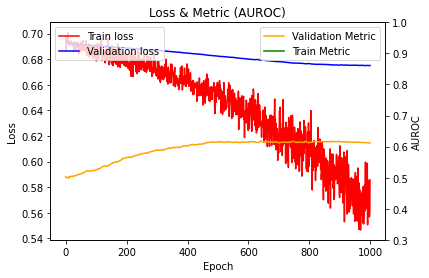

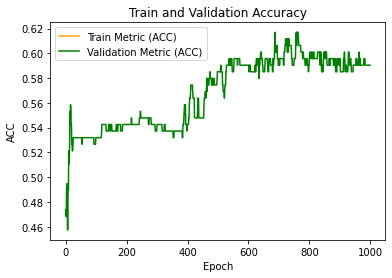

/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



The fold is  2

val_index :  [  5  10  12  14  17  24  32  35  39  40  44  47  50  56  59  60  62  63
  66  74  90  93  99 101 108 116 118 120 123 124 125 126 128 130 131 132
 137 139 141 149 153 158 161 163 165 166 174 178 180 181 188 196 205 215
 218 225 229 230 242 243 246 253 255 259 267 279 284 296 297 306 307 322
 335 336 338 340 343 346 347 352 353 354 366 375 376 378 383 388 390 395
 396 400 401 402 404 405 408 412 416 420 421 424 429 432 438 439 444 445
 449 452 453 454 460 462 463 466 471 489 491 493 494 500 501 504 509 511
 516 523 524 529 530 531 534 539 543 544 548 549 552 554 557 567 569 571
 572 575 578 588 592 597 599 603 611 612 618 622 623 625 630 631 632 642
 648 651 652 661 664 669 671 675 683 684 686 689 695 708 711 713 716 720
 727 737 739 741 745 746 749 752]
The number of train dataset 565
The number of validation dataset 188
The number of test dataset 189
=====epoch 1


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


validation loss 0.6991094290569946
running_loss and val_running_loss:  0.6885146372400608 0.6991094290569946
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


test_auc [0.50056117 0.50056117]
test acc :  0.47619047619047616
=====epoch 2


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


validation loss 0.6985979798147104
running_loss and val_running_loss:  0.7025089359158945 0.6985979798147104
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


test_auc [0.5010101 0.5010101]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 3


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


validation loss 0.698072608333012
running_loss and val_running_loss:  0.6940948110362573 0.698072608333012
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


test_auc [0.50415264 0.50415264]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 4


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


validation loss 0.6975675156904829
running_loss and val_running_loss:  0.7019649577836057 0.6975675156904829
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]


test_auc [0.50987654 0.50987654]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.95it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 5


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.6970594845263149
running_loss and val_running_loss:  0.7013374018502362 0.6970594845263149
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


test_auc [0.50976431 0.50976431]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 6


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6965619753719987
running_loss and val_running_loss:  0.6954619483834498 0.6965619753719987
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.14it/s]


test_auc [0.51436588 0.51436588]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 7


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


validation loss 0.6960852057402203
running_loss and val_running_loss:  0.7001695410958056 0.6960852057402203
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


test_auc [0.5174523  0.51750842]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 8


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


validation loss 0.6956207094946333
running_loss and val_running_loss:  0.6961572881885504 0.6956207094946333
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.38it/s]


test_auc [0.52210999 0.52210999]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 9


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


validation loss 0.6951774113249941
running_loss and val_running_loss:  0.6976403547847311 0.6951774113249941
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


test_auc [0.5295174 0.5295174]
test acc :  0.47619047619047616


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.47it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 10


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


validation loss 0.694751321672511
running_loss and val_running_loss:  0.6969303533793029 0.694751321672511
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


test_auc [0.5372615 0.5372615]
test acc :  0.49206349206349204


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 11


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.6943513465840693
running_loss and val_running_loss:  0.6957343022267835 0.6943513465840693
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.28it/s]


test_auc [0.54511785 0.54511785]
test acc :  0.49206349206349204


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 12


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6939752585258983
running_loss and val_running_loss:  0.6928127865134046 0.6939752585258983
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s]


test_auc [0.55061728 0.55061728]
test acc :  0.48677248677248675


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 13


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


validation loss 0.6936214300292508
running_loss and val_running_loss:  0.695129182295021 0.6936214300292508
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.98it/s]


test_auc [0.55656566 0.55656566]
test acc :  0.5132275132275133


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 14


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6932924947189719
running_loss and val_running_loss:  0.6935690826643642 0.6932924947189719
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


test_auc [0.56262626 0.56262626]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 15


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


validation loss 0.6929893175256168
running_loss and val_running_loss:  0.6917430949954595 0.6929893175256168
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


test_auc [0.56498316 0.56498316]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 16


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.6927178264558272
running_loss and val_running_loss:  0.6927472630284918 0.6927178264558272
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]


test_auc [0.5667789 0.5667789]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 17


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6924791278021182
running_loss and val_running_loss:  0.6940739213642021 0.6924791278021182
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]


test_auc [0.56756453 0.56756453]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 18


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


validation loss 0.6922723352688248
running_loss and val_running_loss:  0.6920305186743433 0.6922723352688248
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]


test_auc [0.5674523 0.5674523]
test acc :  0.5661375661375662


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 19


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6920715354252038
running_loss and val_running_loss:  0.6919498735030492 0.6920715354252038
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]


test_auc [0.56621773 0.56621773]
test acc :  0.5714285714285714


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 20


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.6918744403627938
running_loss and val_running_loss:  0.6893011719503448 0.6918744403627938
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


test_auc [0.5674523 0.5674523]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 21


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


validation loss 0.6916858961775466
running_loss and val_running_loss:  0.6906654352590197 0.6916858961775466
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


test_auc [0.56666667 0.56666667]
test acc :  0.5238095238095238


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 22


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


validation loss 0.6915351413215192
running_loss and val_running_loss:  0.6924470102048671 0.6915351413215192
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


test_auc [0.56734007 0.56734007]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 23


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


validation loss 0.6913968926146579
running_loss and val_running_loss:  0.6932447032784232 0.6913968926146579
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]


test_auc [0.56588103 0.56588103]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 24


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


validation loss 0.6912744118374758
running_loss and val_running_loss:  0.6920615870377257 0.6912744118374758
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


test_auc [0.56464646 0.56464646]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 25


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


validation loss 0.6911673085691997
running_loss and val_running_loss:  0.6914599097088757 0.6911673085691997
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]


test_auc [0.56520763 0.56520763]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 26


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


validation loss 0.6910732453633759
running_loss and val_running_loss:  0.6929671012688309 0.6910732453633759
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.78it/s]


test_auc [0.56588103 0.56588103]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 27


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6909983743747772
running_loss and val_running_loss:  0.6915747761435062 0.6909983743747772
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.59it/s]


test_auc [0.5661055 0.5661055]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 28


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


validation loss 0.6909340478900734
running_loss and val_running_loss:  0.6893896689216776 0.6909340478900734
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


test_auc [0.56666667 0.56666667]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 29


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


validation loss 0.690867084566529
running_loss and val_running_loss:  0.691800082722031 0.690867084566529
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]


test_auc [0.56700337 0.56700337]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 30


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.6908023667169194
running_loss and val_running_loss:  0.6834415947165555 0.6908023667169194
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]


test_auc [0.56655443 0.56655443]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 31


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


validation loss 0.6907208380892457
running_loss and val_running_loss:  0.6911988852732184 0.6907208380892457
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.37it/s]


test_auc [0.56632997 0.56632997]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 32


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


validation loss 0.6906496760994778
running_loss and val_running_loss:  0.6892087865125087 0.6906496760994778
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


test_auc [0.56621773 0.56621773]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 33


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.6905779467358486
running_loss and val_running_loss:  0.6865576727611593 0.6905779467358486
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


test_auc [0.5664422 0.5664422]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 34


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


validation loss 0.6904970300361101
running_loss and val_running_loss:  0.689316591849433 0.6904970300361101
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s]


test_auc [0.56689113 0.56689113]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 35


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


validation loss 0.6904199970479944
running_loss and val_running_loss:  0.6888413448964705 0.6904199970479944
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.66it/s]


test_auc [0.56767677 0.56767677]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 36


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


validation loss 0.6903523806535445
running_loss and val_running_loss:  0.6896483724275857 0.6903523806535445
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s]


test_auc [0.5667789 0.5667789]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 37


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


validation loss 0.6903030880715318
running_loss and val_running_loss:  0.6921828449670164 0.6903030880715318
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


test_auc [0.56689113 0.56689113]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 38


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s]


validation loss 0.6902681607020401
running_loss and val_running_loss:  0.690464392910799 0.6902681607020401
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.5667789 0.5667789]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 39


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


validation loss 0.6902396911398254
running_loss and val_running_loss:  0.692515447700458 0.6902396911398254
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


test_auc [0.56621773 0.56621773]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 40


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


validation loss 0.6902217669267505
running_loss and val_running_loss:  0.6913251920843099 0.6902217669267505
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]


test_auc [0.56621773 0.56621773]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 41


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


validation loss 0.6902074316590711
running_loss and val_running_loss:  0.6840387815083063 0.6902074316590711
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.5674523 0.5674523]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 42


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6901787420610854
running_loss and val_running_loss:  0.6910508796824641 0.6901787420610854
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


test_auc [0.56790123 0.56790123]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 43


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]


validation loss 0.6901554656865666
running_loss and val_running_loss:  0.6901133805102174 0.6901554656865666
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]


test_auc [0.56801347 0.56801347]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 44


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


validation loss 0.6901349090961832
running_loss and val_running_loss:  0.6956089324707043 0.6901349090961832
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]


test_auc [0.56868687 0.56868687]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 45


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


validation loss 0.690126793814735
running_loss and val_running_loss:  0.6901613776621236 0.690126793814735
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s]


test_auc [0.5684624 0.5684624]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 46


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


validation loss 0.690118194823876
running_loss and val_running_loss:  0.6864775727304532 0.690118194823876
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


test_auc [0.56857464 0.56857464]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 47


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.6901008182857329
running_loss and val_running_loss:  0.6906645339838796 0.6901008182857329
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


test_auc [0.56902357 0.56902357]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 48


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


validation loss 0.6900769104176541
running_loss and val_running_loss:  0.6851266630318797 0.6900769104176541
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]


test_auc [0.56902357 0.56902357]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 49


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


validation loss 0.6900435748234091
running_loss and val_running_loss:  0.6853648106800523 0.6900435748234091
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


test_auc [0.56823793 0.56823793]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 50


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


validation loss 0.6900085697605287
running_loss and val_running_loss:  0.6904111795257921 0.6900085697605287
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]


test_auc [0.56790123 0.56790123]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 51


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


validation loss 0.6899784340006025
running_loss and val_running_loss:  0.687696150108774 0.6899784340006025
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.38it/s]


test_auc [0.5684624 0.5684624]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 52


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.6899516102124583
running_loss and val_running_loss:  0.6904076526269582 0.6899516102124583
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]


test_auc [0.56857464 0.56857464]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 53


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


validation loss 0.689936231909902
running_loss and val_running_loss:  0.6904021409149014 0.689936231909902
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


test_auc [0.5691358 0.5691358]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 54


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


validation loss 0.6899188972278097
running_loss and val_running_loss:  0.6834483644117 0.6899188972278097
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]


test_auc [0.57025814 0.57025814]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 55


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6898974587167325
running_loss and val_running_loss:  0.6931185882547929 0.6898974587167325
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


test_auc [0.5701459 0.5701459]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 56


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


validation loss 0.6898917841805934
running_loss and val_running_loss:  0.6896998920010637 0.6898917841805934
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.51it/s]


test_auc [0.57160494 0.57160494]
test acc :  0.5291005291005291


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 57


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


validation loss 0.689889017958747
running_loss and val_running_loss:  0.6870260803306988 0.689889017958747
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s]


test_auc [0.57250281 0.57250281]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 58


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


validation loss 0.689883959677349
running_loss and val_running_loss:  0.6911595435991363 0.689883959677349
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]


test_auc [0.57351291 0.57351291]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 59


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


validation loss 0.6898797922086237
running_loss and val_running_loss:  0.6872377436614675 0.6898797922086237
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


test_auc [0.57441077 0.57441077]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 60


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


validation loss 0.6898677466050437
running_loss and val_running_loss:  0.6906235849573773 0.6898677466050437
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]


test_auc [0.57384961 0.57384961]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 61


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


validation loss 0.6898572005301693
running_loss and val_running_loss:  0.6891054187611242 0.6898572005301693
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


test_auc [0.57463524 0.57463524]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 62


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


validation loss 0.6898503416558504
running_loss and val_running_loss:  0.6891204383966781 0.6898503416558504
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]


test_auc [0.57485971 0.57485971]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 63


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


validation loss 0.689844232399646
running_loss and val_running_loss:  0.6870376727208217 0.689844232399646
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


test_auc [0.57530864 0.57530864]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 64


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


validation loss 0.6898421444964336
running_loss and val_running_loss:  0.6926286232240167 0.6898421444964336
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


test_auc [0.57530864 0.57530864]
test acc :  0.5343915343915344


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 65


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


validation loss 0.6898491516263184
running_loss and val_running_loss:  0.6872801147380256 0.6898491516263184
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


test_auc [0.57575758 0.57575758]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 66


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.689854585836983
running_loss and val_running_loss:  0.6882058648186071 0.689854585836983
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s]


test_auc [0.57609428 0.57609428]
test acc :  0.5396825396825397


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 67


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]


validation loss 0.6898478652815523
running_loss and val_running_loss:  0.6876652142768896 0.6898478652815523
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s]


test_auc [0.57676768 0.57676768]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 68


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


validation loss 0.6898286346147762
running_loss and val_running_loss:  0.688565759649423 0.6898286346147762
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]


test_auc [0.57760943 0.57760943]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 69


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


validation loss 0.6898063091482879
running_loss and val_running_loss:  0.6890628895893158 0.6898063091482879
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


test_auc [0.57789001 0.57789001]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 70


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


validation loss 0.6897848718479924
running_loss and val_running_loss:  0.6871510543847508 0.6897848718479924
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


test_auc [0.57800224 0.57800224]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 71


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


validation loss 0.6897684183511563
running_loss and val_running_loss:  0.6955435016838913 0.6897684183511563
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]


test_auc [0.57732884 0.57732884]
test acc :  0.544973544973545


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 72


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


validation loss 0.6897848640837018
running_loss and val_running_loss:  0.6897520795682061 0.6897848640837018
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


test_auc [0.57789001 0.57789001]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 73


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


validation loss 0.6897960710429103
running_loss and val_running_loss:  0.6885113361666835 0.6897960710429103
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


test_auc [0.57968575 0.57968575]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.78it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 74


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


validation loss 0.6898078792744605
running_loss and val_running_loss:  0.6875931533032084 0.6898078792744605
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


test_auc [0.58013468 0.58013468]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 75


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


validation loss 0.6898220676604122
running_loss and val_running_loss:  0.6895829596825531 0.6898220676604122
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


test_auc [0.58103255 0.58103255]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 76


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


validation loss 0.6898432902704439
running_loss and val_running_loss:  0.6843111783730971 0.6898432902704439
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


test_auc [0.58249158 0.58249158]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 77


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


validation loss 0.6898503608784188
running_loss and val_running_loss:  0.6840958520484225 0.6898503608784188
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.58338945 0.58338945]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 78


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


validation loss 0.6898341296975633
running_loss and val_running_loss:  0.6811229889250969 0.6898341296975633
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s]


test_auc [0.58462402 0.58462402]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 79


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6897896964273527
running_loss and val_running_loss:  0.6889750537468553 0.6897896964273527
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


test_auc [0.58372615 0.58372615]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 80


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


validation loss 0.6897435862393526
running_loss and val_running_loss:  0.6854716304279186 0.6897435862393526
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]


test_auc [0.58361392 0.58361392]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 81


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


validation loss 0.6896814872414798
running_loss and val_running_loss:  0.6872297492104875 0.6896814872414798
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s]


test_auc [0.58271605 0.58271605]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 82


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


validation loss 0.6896204508402081
running_loss and val_running_loss:  0.6880874083029923 0.6896204508402081
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s]


test_auc [0.58294052 0.58294052]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 83


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


validation loss 0.689572324532782
running_loss and val_running_loss:  0.6853128248867179 0.689572324532782
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


test_auc [0.58282828 0.58282828]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 84


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


validation loss 0.6895191892361294
running_loss and val_running_loss:  0.6872626291707897 0.6895191892361294
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


test_auc [0.58282828 0.58282828]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 85


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


validation loss 0.6894633569854973
running_loss and val_running_loss:  0.6884776718423148 0.6894633569854973
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s]


test_auc [0.58237935 0.58237935]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 86


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


validation loss 0.6894162589431817
running_loss and val_running_loss:  0.6848613408885812 0.6894162589431817
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.38it/s]


test_auc [0.58260382 0.58260382]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.09it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 87


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


validation loss 0.6893665011146753
running_loss and val_running_loss:  0.6885675558871281 0.6893665011146753
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s]


test_auc [0.58226712 0.58226712]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 88


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6893263320239987
running_loss and val_running_loss:  0.690310008961394 0.6893263320239987
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s]


test_auc [0.5832211  0.58327722]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 89


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


validation loss 0.6892945571762702
running_loss and val_running_loss:  0.6854318353957151 0.6892945571762702
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


test_auc [0.58383838 0.58383838]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 90


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


validation loss 0.6892649482946234
running_loss and val_running_loss:  0.6877660611189819 0.6892649482946234
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s]


test_auc [0.58439955 0.58439955]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.20it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 91


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


validation loss 0.6892433211848394
running_loss and val_running_loss:  0.6894713593548404 0.6892433211848394
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


test_auc [0.58383838 0.58383838]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.40it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 92


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


validation loss 0.6892313533777451
running_loss and val_running_loss:  0.6922965010004271 0.6892313533777451
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.20it/s]


test_auc [0.58439955 0.58439955]
test acc :  0.5555555555555556


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 93


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


validation loss 0.6892268038257409
running_loss and val_running_loss:  0.6831371850323283 0.6892268038257409
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


test_auc [0.58529742 0.58529742]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 94


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


validation loss 0.6892099647768095
running_loss and val_running_loss:  0.6921173575821176 0.6892099647768095
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


test_auc [0.58574635 0.58574635]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 95


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]


validation loss 0.6892060675568611
running_loss and val_running_loss:  0.6832908886544011 0.6892060675568611
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s]


test_auc [0.58776655 0.58776655]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 96


Iteration: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


validation loss 0.689193526789847
running_loss and val_running_loss:  0.6883799089615259 0.689193526789847
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]


test_auc [0.58866442 0.58866442]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 97


Iteration: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


validation loss 0.6891843405861523
running_loss and val_running_loss:  0.6855713799278952 0.6891843405861523
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]


test_auc [0.58945006 0.58945006]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 98


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


validation loss 0.6891692428907553
running_loss and val_running_loss:  0.6807090544915584 0.6891692428907553
====Evaluation
ommitting training evaluation


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]


test_auc [0.58956229 0.58956229]
test acc :  0.5502645502645502


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.03it/s]
/tmp/ipykernel_25848/1598694777.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=====epoch 99


Iteration: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


KeyboardInterrupt: 

In [19]:
torch.manual_seed(runseed)
np.random.seed(runseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(runseed)
    

dataset = torch.load(dataset_dir)

y = []
for i in range(len(dataset)):
    y.append(int(dataset[i].y))

if kfold == 1:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=613)
    skf2 = StratifiedKFold(n_splits=4, shuffle=True, random_state=613)
else :
    skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=613)
    skf2 = StratifiedKFold(n_splits=kfold-1, shuffle=True, random_state=613)
    
x_idx=range(len(dataset))

kfold = 1
for train_val_index, test_index in skf.split(x_idx, y):
    train_val_dataset=[]
    train_dataset=[]
    val_dataset = []
    test_dataset=[]
    print()
    print("The fold is ", kfold)
    print()
    if kfold == 2 and (kfold == 1 or kfold == 0):
        break
    else: 
        test_y=[]
        for j in range(len(train_val_index)):
            train_val_dataset.append(dataset[train_val_index[j]])
        for j in range(len(test_index)):
            test_dataset.append(dataset[test_index[j]])
            test_y.append(int(test_dataset[j].y))
        train_y = []
        train_x_idx = range(len(train_val_dataset))
        for i in range(len(train_val_dataset)):
            train_y.append(int(train_val_dataset[i].y))    
        # print("train_val_index : ", train_val_index)
        # print("train_y : ", train_y)
        # print("test_index : ", test_index)
        # print("test_y: ", test_y)
        tmp = 0
        for train_index, val_index in skf2.split(train_x_idx, train_y):
            tmp=0
        for j in range(len(train_index)):
            train_dataset.append(train_val_dataset[train_index[j]])
        for j in range(len(val_index)):
            val_dataset.append(train_val_dataset[val_index[j]])   
        print("val_index : ", val_index)
        print('The number of train dataset', len(train_dataset))
        print('The number of validation dataset', len(val_dataset))
        print('The number of test dataset', len(test_dataset))
        
        if halfhop == 'yes':
            for i in range(len(train_dataset)):
                transform = HalfHop(alpha=0.5)
                train_dataset[i] = transform(train_dataset[i])
                
        train_loader = DataLoaderFinetune(train_dataset,batch_size=batch_size, shuffle=True, num_workers = num_workers)
        val_loader = DataLoaderFinetune(val_dataset, batch_size=10*batch_size, shuffle=False, num_workers = num_workers)
        test_loader = DataLoaderFinetune(test_dataset, batch_size=10*batch_size, shuffle=False, num_workers = num_workers)
        #set up model
        if model_file == "none":
            model = GNN_graphpred(num_layer, emb_dim, num_tasks, JK = JK, drop_ratio=dropout_ratio, graph_pooling=graph_pooling, gnn_type = gnn_type)
        else:    
            model = GNN_graphpred(num_layer, emb_dim, num_tasks, JK = JK, drop_ratio=dropout_ratio, graph_pooling=graph_pooling, gnn_type = gnn_type)
            checkpoint = torch.load(model_file)
            model_graphcl = graphcl(model.gnn, emb_dim)
            model_graphcl.gnn.load_state_dict(checkpoint)
            model.gnn = model_graphcl.gnn
        model.to(device)
        #set up optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

        train_auc_list = []
        val_auc_list = []
        test_auc_list =  []
        test_acc_list = []
        train_acc_list = []
        val_acc_list = []
        #for roc plot
        test_fper_list = []
        test_tper_list= []
        # for loss plot
        loss_values = []
        val_loss_values = []
        #for AUC plot
        test_auc_mean_list = []
        for epoch in range(1, epochs+1):
            print("=====epoch "+ str(epoch))
            running_loss, val_running_loss, val_y, val_pred = train(model, device, train_loader, val_loader, optimizer, num_tasks=num_tasks, halfhop=halfhop)
            loss_values.append(running_loss)
            val_loss_values.append(val_running_loss)
            print("running_loss and val_running_loss: ", running_loss, val_running_loss)
            print("====Evaluation")
            if eval_train:
                train_auc, _, _, train_acc, train_cm = eval( model, device, train_loader, num_tasks=num_tasks)
            else:
                train_auc = 0
                print("ommitting training evaluation")
            val_auc, _, _, val_acc, val_cm = eval( model, device, val_loader, num_tasks=num_tasks)
            val_auc_list.append(np.mean(val_auc))
            val_acc_list.append(val_acc)
            train_auc_list.append(np.mean(train_auc))
            #train_acc_list.append(train_acc)
            test_auc, test_fper, test_tper, test_acc, test_cm = eval( model, device, test_loader, num_tasks=num_tasks)
            print('test_auc', test_auc)
            print('test acc : ', test_acc)
            #print("test roc list: ", val_auc)
            test_auc_list.append(test_auc)
            test_acc_list.append(test_acc)
            test_auc_mean_list.append(np.mean(test_auc))
            test_fper_list.append(test_fper)
            test_tper_list.append(test_tper)
            
            if epoch == 1:
                max_model = model
            if epoch > 1 :
                max_auc, _, _, _ , _= eval( max_model, device, test_loader, num_tasks=num_tasks)
                max_eval = np.mean(max_auc)
                cur_eval = np.mean(val_auc)
                if cur_eval > max_eval: 
                    max_model = model
                else: 
                    max_model = max_model
            file_name = resultFile_name.split('/')
            weight_path = f'/nasdata3/kyj/graphcl/GraphCL_Automated/transferLearning_MoleculeNet_PPI/bio/fintune_weight/{file_name[-1]}_fold{str(kfold)}_seed{runseed}.pt'
            torch.save(max_model.state_dict(), weight_path)
        # print('val_y', val_y, 'val_pred', val_pred)
        
        print(f'Run Seed {runseed} || validation auc : {np.array(val_auc_list).max()} and test AUC {np.array(test_auc_list)[np.array(val_auc_list).argmax()]} and \
            test acc {np.array(test_acc_list)[np.array(val_auc_list).argmax()]}')
    
        fig, ax1 = plt.subplots()
        ax1.plot(np.array(loss_values), color='red',label='Train loss')
        ax1.plot(np.array(val_loss_values), color='blue', label='Validation loss')
       # ax1.set_ylim(0, 1)
        ax1.legend(loc='upper left')
        ax2 = ax1.twinx()
        ax2.plot(np.array(val_auc_list), color='orange',label='Validation Metric')
        print(np.shape(np.array(train_auc_list)))
        ax2.plot(np.array(train_auc_list), color='green',label='Train Metric')
        ax2.set_ylim(0.3, 1)
        plt.title('Loss & Metric (AUROC)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax2.set_ylabel('AUROC')
        ax2.legend(loc='upper right')
        plt.show()
        plt.close()
        
        #accuracy plot
        plt.plot(np.array(train_acc_list), 'orange',label='Train Metric (ACC)')
        plt.plot(np.array(val_acc_list), 'green', label='Validation Metric (ACC)')
        plt.title('Train and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('ACC')
        plt.legend()
        plt.show()
        plt.close()
        
        #confusion matrix plot 
        
        sns.heatmap(test_cm, annot=True, cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show
        plt.close()
        
        
    kfold += 1